In [1]:
# import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly
import warnings
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# import training and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(6500, 20)
(3500, 19)


In [3]:
# first five records of train data
train_data.head()

Customer Id     Artist Name  Artist Reputation  Height  Width  \
0  fffe3900350033003300   Billy Jenkins               0.26    17.0    6.0   
1  fffe3800330031003900     Jean Bryant               0.28     3.0    3.0   
2  fffe3600370035003100    Laura Miller               0.07     8.0    5.0   
3      fffe350031003300  Robert Chaires               0.12     9.0    NaN   
4  fffe3900320038003400    Rosalyn Krol               0.15    17.0    6.0   

   Weight   Material  Price Of Sculpture  Base Shipping Price International  \
0  4128.0      Brass               13.91                16.27           Yes   
1    61.0      Brass                6.83                15.00            No   
2   237.0       Clay                4.96                21.18            No   
3     NaN  Aluminium                5.81                16.31            No   
4   324.0  Aluminium                3.18                11.94           Yes   

  Express Shipment Installation Included Transport Fragile  \
0              Yes                    No   Airways      No   
1               No                    No  Roadways      No   
2               No                    No  Roadways     Yes   
3               No                    No       NaN      No   
4              Yes                   Yes   Airways      No   

  Customer Information Remote Location Scheduled Date Delivery Date  \
0        Working Class              No       06/07/15      06/03/15   
1        Working Class              No       03/06/17      03/05/17   
2        Working Class             Yes       03/09/15      03/08/15   
3              Wealthy             Yes       05/24/15      05/20/15   
4        Working Class              No       12/18/16      12/14/16   

           Customer Location    Cost  
0     New Michelle, OH 50777 -283.29  
1  New Michaelport, WY 12072 -159.96  
2      Bowmanshire, WA 19241 -154.29  
3       East Robyn, KY 86375 -161.16  
4        Aprilside, PA 52793 -159.23

In [4]:
# Column type
id_column = ["Customer Id"]
categorical_column = ["Material","International","Express Shipment","Installation Included","Transport","Fragile","Customer Information","Remote Location"]
numerical_column = ['Artist Reputation', 'Height', 'Width','Weight','Price Of Sculpture', 'Base Shipping Price']
date_time_column = ['Scheduled Date', 'Delivery Date']
target_column = ['Cost']

In [5]:
print("No. of Training data Customer Id Included in Test data customer id: ",len(train_data[train_data["Customer Id"].isin(test_data["Customer Id"] == True)]))

No. of Training data Customer Id Included in Test data customer id:  0


In [6]:
print("No. of Unique Customer Ids in training set:",train_data["Customer Id"].nunique())
print("No. of Unique Customer Ids in test set:",test_data["Customer Id"].nunique())

No. of Unique Customer Ids in training set: 6500
No. of Unique Customer Ids in test set: 3500


In [7]:
# Drop Customer ID
train_data.drop(labels=["Customer Id"], axis=1, inplace=True)
test_data.drop(labels=["Customer Id"], axis=1, inplace=True)

In [8]:
# Combining train and test data
train_data["is_train"] = True
test_data["is_train"] = False

test_data[target_column[0]] = np.nan
combine_data = pd.concat([train_data, test_data])
combine_data.reset_index(drop=True, inplace = True)
print(combine_data.shape)

(10000, 20)


In [9]:
# Null values in Combine dataset
null_values = combine_data.isnull().sum()
pd.DataFrame({"Null Values" : null_values, 
             "Percentage" : ((null_values*100) / len(combine_data))}).sort_values("Null Values", ascending=False).head(8)

Null Values  Percentage
Cost                      3500       35.00
Transport                 1624       16.24
Artist Reputation          972        9.72
Remote Location            771        7.71
Material                   764        7.64
Weight                     736        7.36
Width                      725        7.25
Height                     494        4.94

### Null Values in Transport Column

In [10]:
combine_data["Transport"].value_counts()

Roadways     3366
Airways      3033
Waterways    1977
Name: Transport, dtype: int64

In [11]:
combine_data["Transport"].fillna("Unknown", inplace=True)

### Null Values in Remote Location Column

In [12]:
combine_data["Remote Location"].value_counts()

No     7383
Yes    1846
Name: Remote Location, dtype: int64

In [13]:
combine_data["Remote Location"].fillna("Unknown", inplace=True)

### Null Values in Material Column

In [14]:
combine_data["Material"].value_counts()

Aluminium    1367
Bronze       1363
Brass        1340
Clay         1313
Wood         1307
Marble       1302
Stone        1244
Name: Material, dtype: int64

In [15]:
temp = pd.DataFrame({"Min_Price":combine_data.groupby("Material").min()["Price Of Sculpture"],
             "Max_Price" : combine_data.groupby("Material").max()["Price Of Sculpture"],
              "Median_Price" : combine_data.groupby("Material").median()["Price Of Sculpture"],
              "Mean_Price" : combine_data.groupby("Material").mean()["Price Of Sculpture"]
             }).sort_values("Max_Price")

temp

Min_Price  Max_Price  Median_Price   Mean_Price
Material                                                  
Wood            3.00      25.13         5.080     5.086266
Aluminium       3.00     131.75         5.440     6.664075
Clay            3.00     280.78         6.100    11.758149
Bronze          3.00    1638.98        12.160    45.912421
Brass           3.01    2700.89        19.615    92.973985
Marble          3.00   93376.59       309.855  2540.158791
Stone           3.20  382385.67       525.095  5815.017886

In [16]:
# Filling null values in material column as per maximum Price of Sculpture of that particular material
combine_data["Material"].fillna(inplace=True , value =combine_data["Price Of Sculpture"].apply(lambda x : temp[temp["Max_Price"]>(x-0.001)]["Max_Price"].idxmin()))

In [17]:
combine_data["Material"].value_counts()

Wood         1793
Aluminium    1479
Bronze       1418
Brass        1363
Clay         1356
Marble       1347
Stone        1244
Name: Material, dtype: int64

### Null Values in Artist Reputation Column

In [18]:
combine_data["Artist Reputation"].isnull().sum()

972

In [19]:
# Below is the list of artist Name who have null values and also have more than one record(with null or not null values) in dataset
null_repu_artist_name = combine_data[combine_data["Artist Reputation"].isnull()]["Artist Name"].to_list()
s = combine_data[combine_data["Artist Name"].isin(null_repu_artist_name)]["Artist Name"].value_counts()
s = s[s>1]
s

Robert Davis        4
Michael White       3
James Smith         3
James White         3
Tracy Anderson      2
Karen Martin        2
Kathleen Brown      2
James Jackson       2
Mark Jones          2
Frank Lopez         2
Walter Patterson    2
Charles Williams    2
Michelle Hu         2
Joseph Moore        2
James Owens         2
William Jones       2
Richard Williams    2
David Brown         2
Mary Todd           2
Richard Brown       2
John Moody          2
John Austin         2
Elizabeth Ross      2
Michael Freeman     2
Michael Davis       2
Linda Smith         2
Joseph Jones        2
Mary Harris         2
Mary Smith          2
Barbara Thomas      2
Nancy Lopez         2
Ann Garcia          2
Name: Artist Name, dtype: int64

In [20]:
# Artist Reputation score by taking maximum value of score of those artist who have null values and also have more than one record with given score
dict_1 = dict(combine_data[combine_data["Artist Name"].isin(s.index)].groupby('Artist Name')["Artist Reputation"].max().dropna())
dict_1

{'Ann Garcia': 0.99,
 'Barbara Thomas': 0.36,
 'Charles Williams': 0.57,
 'Elizabeth Ross': 0.1,
 'Frank Lopez': 0.4,
 'James Jackson': 0.08,
 'James Owens': 0.26,
 'James Smith': 0.63,
 'James White': 0.62,
 'John Austin': 0.23,
 'John Moody': 0.65,
 'Joseph Jones': 0.57,
 'Joseph Moore': 0.26,
 'Karen Martin': 0.82,
 'Kathleen Brown': 0.4,
 'Linda Smith': 0.5,
 'Mark Jones': 0.87,
 'Mary Harris': 0.66,
 'Mary Todd': 0.64,
 'Michael Davis': 0.56,
 'Michael Freeman': 0.68,
 'Michael White': 0.13,
 'Michelle Hu': 0.56,
 'Nancy Lopez': 0.06,
 'Richard Brown': 0.38,
 'Richard Williams': 0.29,
 'Robert Davis': 0.63,
 'Tracy Anderson': 0.61,
 'Walter Patterson': 0.17}

In [21]:
# Fill NA in Artist Reputation column according to the above given Values
combine_data["Artist Reputation"] = combine_data["Artist Reputation"].fillna(value=combine_data["Artist Name"].apply(lambda x : dict_1.get(x)))

In [22]:
combine_data["Artist Reputation"].isnull().sum()

941

After filling above values we are left with 941 null values in Artist reputation column.

In [23]:
# Fill rest of the null values with Median value of the column
combine_data["Artist Reputation"].fillna(combine_data["Artist Reputation"].median(), inplace=True)

### Fill NA values in Weight, Height and Width according to their median values

In [24]:
combine_data["Weight"].fillna(combine_data["Weight"].median(), inplace=True)
combine_data["Height"].fillna(combine_data["Height"].median(), inplace=True)
combine_data["Width"].fillna(combine_data["Width"].median(), inplace=True)

In [25]:
train_df = combine_data[combine_data["is_train"] == True]
test_df = combine_data[combine_data["is_train"] == False]

train_df.drop(["is_train"], axis=1, inplace =True)
test_df.drop(["is_train","Cost"], axis=1, inplace = True)
print(train_df.shape)
print(test_df.shape)

(6500, 19)
(3500, 18)


## Categorical Column

In [26]:
for i in np.arange(len(categorical_column)):
    print("Unique Value in Column {} is {} ".format(categorical_column[i],train_df[categorical_column[i]].unique()))

Unique Value in Column Material is ['Brass' 'Clay' 'Aluminium' 'Wood' 'Marble' 'Bronze' 'Stone'] 
Unique Value in Column International is ['Yes' 'No'] 
Unique Value in Column Express Shipment is ['Yes' 'No'] 
Unique Value in Column Installation Included is ['No' 'Yes'] 
Unique Value in Column Transport is ['Airways' 'Roadways' 'Unknown' 'Waterways'] 
Unique Value in Column Fragile is ['No' 'Yes'] 
Unique Value in Column Customer Information is ['Working Class' 'Wealthy'] 
Unique Value in Column Remote Location is ['No' 'Yes' 'Unknown'] 


In [27]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2,subplot_titles=["Ditribution of Various Material", "Distribution of way of Transport"])
material = train_df["Material"].value_counts()
transport = train_df["Transport"].value_counts()
fig.add_trace(
    go.Bar(x = material.index , y= material.values,showlegend=False, marker= dict(color =material.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = transport.index, y= transport.values,showlegend=False, marker= dict(color =transport.values)), row=1, col=2
)
fig['layout']['xaxis']['title'] = "Material"
fig['layout']['xaxis2']['title'] = 'Transport'
fig['layout']['yaxis']['title'] = 'Count'
fig['layout']['yaxis2']['title'] = 'Count'
fig.show()

In [28]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["International Shipment","Express Shipment","Installation Included"],
                   shared_yaxes=False)
temp_1 = train_df["International"].value_counts()
temp_2 = train_df["Express Shipment"].value_counts()
temp_3 = train_df["Installation Included"].value_counts()
fig.add_trace(
    go.Bar(x = temp_1.index, y= temp_1.values,showlegend=False ,marker = dict(color = temp_1.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = temp_2.index, y= temp_2.values,showlegend=False, marker = dict(color = temp_2.values)), row =1, col=2
)
fig.add_trace(
    go.Bar(x = temp_3.index, y= temp_3.values,showlegend=False, marker = dict(color = temp_3.values)), row =1, col=3
)
fig['layout']['yaxis']['title'] = "Count"
fig.show()

In [29]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["sculpture Fragile","Customer Information","Remote Location"],
                   shared_yaxes=False)
temp_1 = train_df["Fragile"].value_counts()
temp_2 = train_df["Customer Information"].value_counts()
temp_3 = train_df["Remote Location"].value_counts()
fig.add_trace(
    go.Bar(x = temp_1.index, y= temp_1.values,showlegend=False ,marker = dict(color = temp_1.values)), row =1, col=1
)
fig.add_trace(
    go.Bar(x = temp_2.index, y= temp_2.values,showlegend=False, marker = dict(color = temp_2.values)), row =1, col=2
)
fig.add_trace(
    go.Bar(x = temp_3.index, y= temp_3.values,showlegend=False, marker = dict(color = temp_3.values)), row =1, col=3
)
fig['layout']['yaxis']['title'] = "Count"
fig.show()

## Numerical Column

In [30]:
train_df.describe()

Artist Reputation  Base Shipping Price          Cost       Height  \
count        6500.000000          6500.000000  6.500000e+03  6500.000000   
mean            0.460388            37.407174  1.713920e+04    21.664308   
std             0.250485            26.873519  2.406579e+05    11.625070   
min             0.000000            10.000000 -8.801727e+05     3.000000   
25%             0.270000            16.700000  1.884400e+02    13.000000   
50%             0.450000            23.505000  3.820650e+02    20.000000   
75%             0.640000            57.905000  1.156115e+03    29.000000   
max             1.000000            99.980000  1.114343e+07    73.000000   

       Price Of Sculpture        Weight        Width  
count          6500.00000  6.500000e+03  6500.000000  
mean           1192.42009  3.647828e+05     9.472308  
std            8819.61675  2.556817e+06     5.188552  
min               3.00000  3.000000e+00     2.000000  
25%               5.23000  5.940000e+02     6.000000  
50%               8.02500  3.032000e+03     8.000000  
75%              89.47000  2.656600e+04    11.000000  
max          382385.67000  1.179279e+08    50.000000

Here the cost is showing Negative values

In [28]:
print("No.of records having cost as negative value", len(train_df[train_df['Cost']<0]))

No.of records having cost as negative value 659


In [29]:
train_df[train_df["Cost"]<0].head().sort_values('Cost')

Artist Name  Artist Reputation  Base Shipping Price    Cost  \
0   Billy Jenkins               0.26                16.27 -283.29   
3  Robert Chaires               0.12                16.31 -161.16   
1     Jean Bryant               0.28                15.00 -159.96   
4    Rosalyn Krol               0.15                11.94 -159.23   
2    Laura Miller               0.07                21.18 -154.29   

  Customer Information          Customer Location Delivery Date  \
0        Working Class     New Michelle, OH 50777      06/03/15   
3              Wealthy       East Robyn, KY 86375      05/20/15   
1        Working Class  New Michaelport, WY 12072      03/05/17   
4        Working Class        Aprilside, PA 52793      12/14/16   
2        Working Class      Bowmanshire, WA 19241      03/08/15   

  Express Shipment Fragile  Height Installation Included International  \
0              Yes      No    17.0                    No           Yes   
3               No      No     9.0                    No            No   
1               No      No     3.0                    No            No   
4              Yes      No    17.0                   Yes           Yes   
2               No     Yes     8.0                    No            No   

    Material  Price Of Sculpture Remote Location Scheduled Date Transport  \
0      Brass               13.91              No       06/07/15   Airways   
3  Aluminium                5.81             Yes       05/24/15   Unknown   
1      Brass                6.83              No       03/06/17  Roadways   
4  Aluminium                3.18              No       12/18/16   Airways   
2       Clay                4.96             Yes       03/09/15  Roadways   

   Weight  Width  
0  4128.0    6.0  
3  3032.0    8.0  
1    61.0    3.0  
4   324.0    6.0  
2   237.0    5.0

In [30]:
train_df["Cost"] = np.abs(train_df["Cost"])
train_df["Cost"] = np.log1p(train_df["Cost"])

In [31]:
train_df.head(100)

Artist Name  Artist Reputation  Base Shipping Price      Cost  \
0    Billy Jenkins               0.26                16.27  5.649995   
1      Jean Bryant               0.28                15.00  5.081156   
2     Laura Miller               0.07                21.18  5.045294   
3   Robert Chaires               0.12                16.31  5.088584   
4     Rosalyn Krol               0.15                11.94  5.076610   
..             ...                ...                  ...       ...   
95  Charles Decker               0.45                34.46  7.666831   
96     Taylor Bodi               0.86                17.02  7.310149   
97  Joseph Forsyth               0.99                21.85  6.442110   
98  Shanna Davison               0.27                29.16  5.821654   
99  Richard Ortega               0.42                23.52  6.316334   

   Customer Information           Customer Location Delivery Date  \
0         Working Class      New Michelle, OH 50777      06/03/15   
1         Working Class   New Michaelport, WY 12072      03/05/17   
2         Working Class       Bowmanshire, WA 19241      03/08/15   
3               Wealthy        East Robyn, KY 86375      05/20/15   
4         Working Class         Aprilside, PA 52793      12/14/16   
..                  ...                         ...           ...   
95        Working Class        Obrienside, MT 61007      04/02/17   
96        Working Class       Lake Rachel, WA 97334      10/07/16   
97        Working Class    Alejandrashire, WI 87220      01/19/18   
98        Working Class  East Abigailstad, MA 42359      01/14/15   
99              Wealthy     Samanthaburgh, WY 19962      04/12/15   

   Express Shipment Fragile  Height Installation Included International  \
0               Yes      No    17.0                    No           Yes   
1                No      No     3.0                    No            No   
2                No     Yes     8.0                    No            No   
3                No      No     9.0                    No            No   
4               Yes      No    17.0                   Yes           Yes   
..              ...     ...     ...                   ...           ...   
95               No      No    35.0                    No            No   
96              Yes      No    14.0                   Yes            No   
97               No      No     8.0                    No            No   
98               No     Yes    37.0                   Yes           Yes   
99               No     Yes    24.0                   Yes           Yes   

     Material  Price Of Sculpture Remote Location Scheduled Date  Transport  \
0       Brass               13.91              No       06/07/15    Airways   
1       Brass                6.83              No       03/06/17   Roadways   
2        Clay                4.96             Yes       03/09/15   Roadways   
3   Aluminium                5.81             Yes       05/24/15    Unknown   
4   Aluminium                3.18              No       12/18/16    Airways   
..        ...                 ...             ...            ...        ...   
95      Brass               88.84              No       03/30/17    Unknown   
96      Brass                8.30             Yes       10/03/16    Unknown   
97  Aluminium                6.92              No       01/17/18  Waterways   
98       Clay               28.53              No       01/10/15  Waterways   
99       Clay               32.42              No       04/11/15    Airways   

    Weight  Width  
0   4128.0    6.0  
1     61.0    3.0  
2    237.0    5.0  
3   3032.0    8.0  
4    324.0    6.0  
..     ...    ...  
95  3032.0   13.0  
96  3694.0    7.0  
97   149.0    8.0  
98  7365.0   16.0  
99  4848.0   17.0  

[100 rows x 19 columns]

In [32]:
train_df["Cost"].isnull().sum()

0

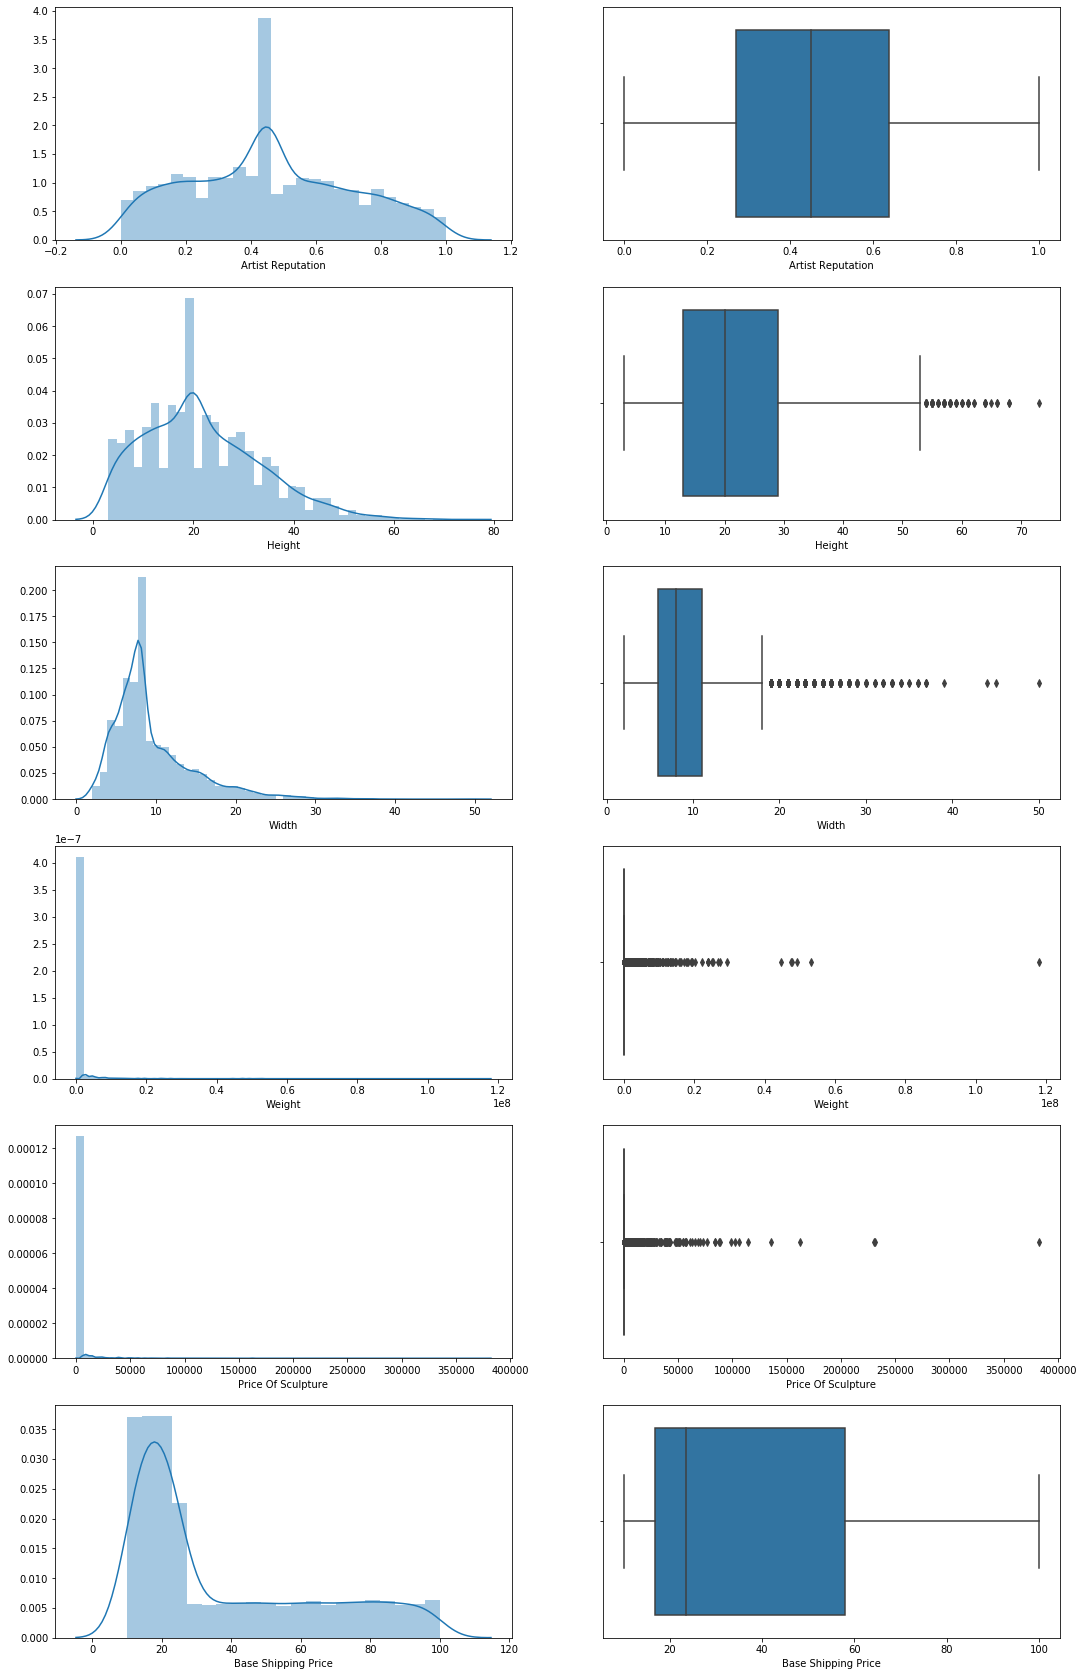

In [36]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize = (18,30))
for i in np.arange(len(numerical_column)):
        sns.distplot(train_df[numerical_column[i]], ax=ax[i][0])
        sns.boxplot(train_df[numerical_column[i]], ax=ax[i][1])
plt.show()

## Remove Outliers

In [33]:
train_df.drop(6133, axis=0, inplace=True)

In [34]:
train_df.shape

(6499, 19)

## Categorical Column Vs Target Column

In [39]:
fig = px.box(data_frame=train_df, x= "Material", y="Cost", color="Material")
fig.update_layout(showlegend= False, title = "Material Wise description of Cost", title_x =0.5)
fig.update_xaxes(categoryorder = "median ascending")
fig.show()

In [40]:
fig = px.box(data_frame=train_df, x = "Transport", y="Cost", color ="Transport")
fig.update_xaxes(categoryorder = "median ascending")
fig.update_layout(title = "Transport Wise description of Cost", showlegend = False, title_x = 0.5)
fig.show()

In [41]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Shipment International wise description of Cost","Express Shipment wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["International"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Express Shipment"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

In [42]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Included Installation wise description of Cost","Sculpture Fragile wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["Installation Included"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Fragile"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

In [43]:
fig = make_subplots(rows=1 , cols=2, subplot_titles=["Customer Information wise description of Cost","Remote Location wise description of Cost"])
fig.add_trace(
        go.Box(x = train_df["Customer Information"] , y = train_df["Cost"],showlegend = False),row=1, col=1
)
fig.add_trace(
        go.Box(x = train_df["Remote Location"] , y = train_df["Cost"],showlegend = False),row=1, col=2
)
fig['layout']['yaxis']['title'] = "Cost"
fig['layout']['yaxis2']['title'] ="Cost"
fig.show()

## Numerical Column

In [35]:
train_df.corr()

Artist Reputation  Base Shipping Price      Cost  \
Artist Reputation             1.000000            -0.012001  0.324593   
Base Shipping Price          -0.012001             1.000000  0.609900   
Cost                          0.324593             0.609900  1.000000   
Height                       -0.001599             0.342959  0.453449   
Price Of Sculpture            0.046924             0.158795  0.492192   
Weight                        0.009851             0.174755  0.491518   
Width                        -0.009003             0.314578  0.449116   

                       Height  Price Of Sculpture    Weight     Width  
Artist Reputation   -0.001599            0.046924  0.009851 -0.009003  
Base Shipping Price  0.342959            0.158795  0.174755  0.314578  
Cost                 0.453449            0.492192  0.491518  0.449116  
Height               1.000000            0.198859  0.237923  0.706372  
Price Of Sculpture   0.198859            1.000000  0.817900  0.289395  
Weight               0.237923            0.817900  1.000000  0.321190  
Width                0.706372            0.289395  0.321190  1.000000

## Numerical Column Vs Target Column

In [45]:
fig = px.scatter(x = train_df["Artist Reputation"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Artist Reputation and Cost", title_x = 0.5)
fig.update_xaxes(title = "Artist Reputation Score")
fig.update_yaxes(title = "Cost")
fig.show()

In [46]:
fig = px.scatter(x = train_df["Height"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between height and Cost", title_x = 0.5)
fig.update_xaxes(title = "Height")
fig.update_yaxes(title = "Cost")
fig.show()

In [47]:
fig = px.scatter(x = train_df["Width"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Width and Cost", title_x = 0.5)
fig.update_xaxes(title = "Width")
fig.update_yaxes(title = "Cost")
fig.show()

In [48]:
fig = px.scatter(x = train_df["Weight"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Weight and Cost", title_x = 0.5)
fig.update_xaxes(title = "Weight")
fig.update_yaxes(title = "Cost")
fig.show()

In [49]:
fig = px.scatter(x = train_df["Price Of Sculpture"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Price Of Sculpture and Cost", title_x = 0.5)
fig.update_xaxes(title = "Price Of Sculpture")
fig.update_yaxes(title = "Cost")
fig.show()

In [50]:
fig = px.scatter(x = train_df["Base Shipping Price"] , y = train_df["Cost"])
fig.update_layout(title = "Scatter Plot Showing Correlation between Base Shipping Price and Cost", title_x = 0.5)
fig.update_xaxes(title = "Base Shipping Price")
fig.update_yaxes(title = "Cost")
fig.show()

In [36]:
train_df.head()

Artist Name  Artist Reputation  Base Shipping Price      Cost  \
0   Billy Jenkins               0.26                16.27  5.649995   
1     Jean Bryant               0.28                15.00  5.081156   
2    Laura Miller               0.07                21.18  5.045294   
3  Robert Chaires               0.12                16.31  5.088584   
4    Rosalyn Krol               0.15                11.94  5.076610   

  Customer Information          Customer Location Delivery Date  \
0        Working Class     New Michelle, OH 50777      06/03/15   
1        Working Class  New Michaelport, WY 12072      03/05/17   
2        Working Class      Bowmanshire, WA 19241      03/08/15   
3              Wealthy       East Robyn, KY 86375      05/20/15   
4        Working Class        Aprilside, PA 52793      12/14/16   

  Express Shipment Fragile  Height Installation Included International  \
0              Yes      No    17.0                    No           Yes   
1               No      No     3.0                    No            No   
2               No     Yes     8.0                    No            No   
3               No      No     9.0                    No            No   
4              Yes      No    17.0                   Yes           Yes   

    Material  Price Of Sculpture Remote Location Scheduled Date Transport  \
0      Brass               13.91              No       06/07/15   Airways   
1      Brass                6.83              No       03/06/17  Roadways   
2       Clay                4.96             Yes       03/09/15  Roadways   
3  Aluminium                5.81             Yes       05/24/15   Unknown   
4  Aluminium                3.18              No       12/18/16   Airways   

   Weight  Width  
0  4128.0    6.0  
1    61.0    3.0  
2   237.0    5.0  
3  3032.0    8.0  
4   324.0    6.0

In [37]:
# Date and time Column
train_df["Scheduled Date"] = pd.to_datetime(train_df["Scheduled Date"])
train_df["Delivery Date"] = pd.to_datetime(train_df["Delivery Date"])

train_df["days"] = (train_df["Delivery Date"] - train_df["Scheduled Date"]).dt.days
train_df["month"] =train_df["Delivery Date"].dt.month 
train_df["year"] = train_df["Delivery Date"].dt.year
train_df["day_of_week"] = train_df["Delivery Date"].dt.dayofweek


test_df["Scheduled Date"] = pd.to_datetime(test_df["Scheduled Date"])
test_df["Delivery Date"] = pd.to_datetime(test_df["Delivery Date"])

test_df["days"] = (test_df["Delivery Date"] - test_df["Scheduled Date"]).dt.days
test_df["month"] =test_df["Delivery Date"].dt.month 
test_df["year"] = test_df["Delivery Date"].dt.year
test_df["day_of_week"] = test_df["Delivery Date"].dt.dayofweek


In [39]:
# Drop Name , Address and Date and Time Column
train_df.drop(labels=["Artist Name","Customer Location","Delivery Date","Scheduled Date",'days'], axis=1, inplace=True)
test_df.drop(labels=["Artist Name","Customer Location","Delivery Date","Scheduled Date",'days'], axis=1, inplace=True)

In [40]:
# Label Encoder for Categorical Column
train_df["International"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Express Shipment"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Installation Included"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Fragile"].replace({'Yes':1,'No':0}, inplace=True)
train_df["Customer Information"].replace({'Working Class':0, 'Wealthy':1}, inplace=True)

test_df["International"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Express Shipment"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Installation Included"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Fragile"].replace({'Yes':1,'No':0}, inplace=True)
test_df["Customer Information"].replace({'Working Class':0, 'Wealthy':1},inplace= True)

In [41]:
# Feature Column and Target Column Split
X_train = train_df.drop("Cost", axis=1)
y_train = train_df["Cost"]
X_test = test_df

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6499, 17)
(3500, 17)
(6499,)


### CAT BOOST

In [42]:
training_accuracy =[]
validation_accuracy = []
y_test_prediction =[]
k_fold = KFold(n_splits=5,shuffle=True, random_state=101)
for fold_index , (train_index, val_index) in enumerate(k_fold.split(X_train)):
    print("K_Fold_Value ", fold_index)
    X_train_ , y_train_ = X_train.iloc[train_index] ,y_train.iloc[train_index]
    X_validation , y_validation = X_train.iloc[val_index], y_train.iloc[val_index]
    
    cat_boost = CatBoostRegressor(learning_rate=0.09, n_estimators=2000, random_state=101,max_depth=5, 
                                  cat_features=['Material','Transport','Remote Location','month','year','day_of_week'],
                                 colsample_bylevel=0.9)
    cat_boost.fit(X_train_,y_train_)
    
    y_train_prediction = cat_boost.predict(X_train_)
    y_validation_prediction = cat_boost.predict(X_validation)
    y_test_prediction.append(cat_boost.predict(X_test))
    
    training_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_train_), np.expm1(y_train_prediction))))
    validation_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_validation), np.expm1(y_validation_prediction))))

y_test_prediction = np.mean(y_test_prediction, axis=0)
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

K_Fold_Value  0
0:	learn: 1.5235252	total: 202ms	remaining: 6m 43s
1:	learn: 1.4136626	total: 217ms	remaining: 3m 37s
2:	learn: 1.3173218	total: 239ms	remaining: 2m 38s
3:	learn: 1.2277718	total: 254ms	remaining: 2m 6s
4:	learn: 1.1500097	total: 269ms	remaining: 1m 47s
5:	learn: 1.0759199	total: 301ms	remaining: 1m 39s
6:	learn: 1.0076889	total: 318ms	remaining: 1m 30s
7:	learn: 0.9520074	total: 333ms	remaining: 1m 22s
8:	learn: 0.8987552	total: 351ms	remaining: 1m 17s
9:	learn: 0.8492013	total: 367ms	remaining: 1m 13s
10:	learn: 0.8072715	total: 386ms	remaining: 1m 9s
11:	learn: 0.7681128	total: 406ms	remaining: 1m 7s
12:	learn: 0.7345870	total: 448ms	remaining: 1m 8s
13:	learn: 0.7025498	total: 463ms	remaining: 1m 5s
14:	learn: 0.6732089	total: 478ms	remaining: 1m 3s
15:	learn: 0.6473368	total: 502ms	remaining: 1m 2s
16:	learn: 0.6237136	total: 517ms	remaining: 1m
17:	learn: 0.6024088	total: 535ms	remaining: 58.9s
18:	learn: 0.5827571	total: 549ms	remaining: 57.2s
19:	learn: 0.568064

162:	learn: 0.2827001	total: 3.58s	remaining: 40.3s
163:	learn: 0.2822062	total: 3.6s	remaining: 40.3s
164:	learn: 0.2810784	total: 3.62s	remaining: 40.2s
165:	learn: 0.2810092	total: 3.64s	remaining: 40.2s
166:	learn: 0.2809520	total: 3.65s	remaining: 40.1s
167:	learn: 0.2805974	total: 3.66s	remaining: 39.9s
168:	learn: 0.2797910	total: 3.69s	remaining: 40s
169:	learn: 0.2794475	total: 3.71s	remaining: 39.9s
170:	learn: 0.2787703	total: 3.72s	remaining: 39.8s
171:	learn: 0.2784075	total: 3.74s	remaining: 39.8s
172:	learn: 0.2779940	total: 3.76s	remaining: 39.7s
173:	learn: 0.2776343	total: 3.77s	remaining: 39.6s
174:	learn: 0.2773188	total: 3.79s	remaining: 39.5s
175:	learn: 0.2761356	total: 3.81s	remaining: 39.5s
176:	learn: 0.2756932	total: 3.84s	remaining: 39.6s
177:	learn: 0.2752214	total: 3.86s	remaining: 39.5s
178:	learn: 0.2749911	total: 3.88s	remaining: 39.5s
179:	learn: 0.2747331	total: 3.9s	remaining: 39.4s
180:	learn: 0.2746975	total: 3.91s	remaining: 39.3s
181:	learn: 0.27

330:	learn: 0.2399206	total: 6.98s	remaining: 35.2s
331:	learn: 0.2395915	total: 7.01s	remaining: 35.2s
332:	learn: 0.2393756	total: 7.03s	remaining: 35.2s
333:	learn: 0.2391452	total: 7.05s	remaining: 35.1s
334:	learn: 0.2391382	total: 7.06s	remaining: 35.1s
335:	learn: 0.2387588	total: 7.1s	remaining: 35.1s
336:	learn: 0.2385961	total: 7.11s	remaining: 35.1s
337:	learn: 0.2385035	total: 7.13s	remaining: 35s
338:	learn: 0.2381371	total: 7.14s	remaining: 35s
339:	learn: 0.2378201	total: 7.16s	remaining: 35s
340:	learn: 0.2376645	total: 7.18s	remaining: 34.9s
341:	learn: 0.2376261	total: 7.19s	remaining: 34.9s
342:	learn: 0.2374655	total: 7.21s	remaining: 34.8s
343:	learn: 0.2374387	total: 7.23s	remaining: 34.8s
344:	learn: 0.2374153	total: 7.25s	remaining: 34.8s
345:	learn: 0.2372530	total: 7.26s	remaining: 34.7s
346:	learn: 0.2371599	total: 7.28s	remaining: 34.7s
347:	learn: 0.2369554	total: 7.3s	remaining: 34.7s
348:	learn: 0.2367775	total: 7.32s	remaining: 34.6s
349:	learn: 0.236672

490:	learn: 0.2202125	total: 9.91s	remaining: 30.5s
491:	learn: 0.2201905	total: 9.93s	remaining: 30.4s
492:	learn: 0.2200675	total: 9.96s	remaining: 30.4s
493:	learn: 0.2199641	total: 9.98s	remaining: 30.4s
494:	learn: 0.2199502	total: 10s	remaining: 30.4s
495:	learn: 0.2199413	total: 10s	remaining: 30.4s
496:	learn: 0.2198169	total: 10s	remaining: 30.3s
497:	learn: 0.2198102	total: 10s	remaining: 30.3s
498:	learn: 0.2195342	total: 10.1s	remaining: 30.3s
499:	learn: 0.2194283	total: 10.1s	remaining: 30.2s
500:	learn: 0.2193999	total: 10.1s	remaining: 30.2s
501:	learn: 0.2191156	total: 10.1s	remaining: 30.2s
502:	learn: 0.2190999	total: 10.1s	remaining: 30.1s
503:	learn: 0.2189461	total: 10.1s	remaining: 30.1s
504:	learn: 0.2187876	total: 10.2s	remaining: 30.1s
505:	learn: 0.2184869	total: 10.2s	remaining: 30.1s
506:	learn: 0.2183670	total: 10.2s	remaining: 30s
507:	learn: 0.2182965	total: 10.2s	remaining: 30s
508:	learn: 0.2181308	total: 10.3s	remaining: 30s
509:	learn: 0.2180988	tota

650:	learn: 0.2046480	total: 13.4s	remaining: 27.7s
651:	learn: 0.2046040	total: 13.4s	remaining: 27.7s
652:	learn: 0.2044081	total: 13.4s	remaining: 27.6s
653:	learn: 0.2042402	total: 13.4s	remaining: 27.6s
654:	learn: 0.2040365	total: 13.4s	remaining: 27.6s
655:	learn: 0.2040309	total: 13.4s	remaining: 27.5s
656:	learn: 0.2039708	total: 13.5s	remaining: 27.5s
657:	learn: 0.2038303	total: 13.5s	remaining: 27.5s
658:	learn: 0.2036655	total: 13.5s	remaining: 27.5s
659:	learn: 0.2034888	total: 13.5s	remaining: 27.4s
660:	learn: 0.2034141	total: 13.5s	remaining: 27.4s
661:	learn: 0.2033669	total: 13.5s	remaining: 27.4s
662:	learn: 0.2031892	total: 13.6s	remaining: 27.4s
663:	learn: 0.2031700	total: 13.6s	remaining: 27.3s
664:	learn: 0.2030812	total: 13.6s	remaining: 27.3s
665:	learn: 0.2028802	total: 13.6s	remaining: 27.3s
666:	learn: 0.2028636	total: 13.7s	remaining: 27.3s
667:	learn: 0.2028116	total: 13.7s	remaining: 27.3s
668:	learn: 0.2026432	total: 13.7s	remaining: 27.2s
669:	learn: 

812:	learn: 0.1925291	total: 16.7s	remaining: 24.3s
813:	learn: 0.1924788	total: 16.7s	remaining: 24.3s
814:	learn: 0.1923886	total: 16.7s	remaining: 24.3s
815:	learn: 0.1922120	total: 16.7s	remaining: 24.3s
816:	learn: 0.1921408	total: 16.7s	remaining: 24.2s
817:	learn: 0.1919695	total: 16.8s	remaining: 24.2s
818:	learn: 0.1918373	total: 16.8s	remaining: 24.2s
819:	learn: 0.1918000	total: 16.8s	remaining: 24.2s
820:	learn: 0.1917947	total: 16.8s	remaining: 24.1s
821:	learn: 0.1916733	total: 16.8s	remaining: 24.1s
822:	learn: 0.1916474	total: 16.9s	remaining: 24.1s
823:	learn: 0.1916022	total: 16.9s	remaining: 24.1s
824:	learn: 0.1915733	total: 16.9s	remaining: 24.1s
825:	learn: 0.1914468	total: 16.9s	remaining: 24.1s
826:	learn: 0.1913766	total: 16.9s	remaining: 24s
827:	learn: 0.1913580	total: 17s	remaining: 24s
828:	learn: 0.1912443	total: 17s	remaining: 24s
829:	learn: 0.1911559	total: 17s	remaining: 24s
830:	learn: 0.1911293	total: 17s	remaining: 23.9s
831:	learn: 0.1911061	total:

976:	learn: 0.1827638	total: 19.8s	remaining: 20.8s
977:	learn: 0.1827068	total: 19.9s	remaining: 20.7s
978:	learn: 0.1826618	total: 19.9s	remaining: 20.7s
979:	learn: 0.1826571	total: 19.9s	remaining: 20.7s
980:	learn: 0.1825903	total: 19.9s	remaining: 20.7s
981:	learn: 0.1825690	total: 19.9s	remaining: 20.7s
982:	learn: 0.1825197	total: 19.9s	remaining: 20.6s
983:	learn: 0.1823765	total: 20s	remaining: 20.6s
984:	learn: 0.1823110	total: 20s	remaining: 20.6s
985:	learn: 0.1822376	total: 20s	remaining: 20.6s
986:	learn: 0.1821672	total: 20s	remaining: 20.5s
987:	learn: 0.1820681	total: 20s	remaining: 20.5s
988:	learn: 0.1820333	total: 20.1s	remaining: 20.5s
989:	learn: 0.1819655	total: 20.1s	remaining: 20.5s
990:	learn: 0.1818525	total: 20.1s	remaining: 20.5s
991:	learn: 0.1817137	total: 20.2s	remaining: 20.5s
992:	learn: 0.1816736	total: 20.2s	remaining: 20.5s
993:	learn: 0.1816553	total: 20.2s	remaining: 20.5s
994:	learn: 0.1814850	total: 20.2s	remaining: 20.4s
995:	learn: 0.1814564	

1133:	learn: 0.1740358	total: 22.6s	remaining: 17.2s
1134:	learn: 0.1739644	total: 22.6s	remaining: 17.2s
1135:	learn: 0.1739376	total: 22.6s	remaining: 17.2s
1136:	learn: 0.1738626	total: 22.6s	remaining: 17.2s
1137:	learn: 0.1738434	total: 22.7s	remaining: 17.2s
1138:	learn: 0.1738379	total: 22.7s	remaining: 17.1s
1139:	learn: 0.1737593	total: 22.7s	remaining: 17.1s
1140:	learn: 0.1737210	total: 22.7s	remaining: 17.1s
1141:	learn: 0.1736477	total: 22.7s	remaining: 17.1s
1142:	learn: 0.1736317	total: 22.8s	remaining: 17.1s
1143:	learn: 0.1735936	total: 22.8s	remaining: 17s
1144:	learn: 0.1735567	total: 22.8s	remaining: 17s
1145:	learn: 0.1735294	total: 22.8s	remaining: 17s
1146:	learn: 0.1734784	total: 22.8s	remaining: 17s
1147:	learn: 0.1734550	total: 22.9s	remaining: 17s
1148:	learn: 0.1734415	total: 22.9s	remaining: 16.9s
1149:	learn: 0.1734254	total: 22.9s	remaining: 16.9s
1150:	learn: 0.1733759	total: 22.9s	remaining: 16.9s
1151:	learn: 0.1733331	total: 22.9s	remaining: 16.9s
115

1297:	learn: 0.1671675	total: 26.3s	remaining: 14.2s
1298:	learn: 0.1671450	total: 26.3s	remaining: 14.2s
1299:	learn: 0.1671296	total: 26.3s	remaining: 14.2s
1300:	learn: 0.1670621	total: 26.4s	remaining: 14.2s
1301:	learn: 0.1670028	total: 26.4s	remaining: 14.2s
1302:	learn: 0.1669801	total: 26.4s	remaining: 14.1s
1303:	learn: 0.1669659	total: 26.5s	remaining: 14.1s
1304:	learn: 0.1669308	total: 26.5s	remaining: 14.1s
1305:	learn: 0.1669093	total: 26.5s	remaining: 14.1s
1306:	learn: 0.1668766	total: 26.6s	remaining: 14.1s
1307:	learn: 0.1667612	total: 26.6s	remaining: 14.1s
1308:	learn: 0.1667574	total: 26.6s	remaining: 14s
1309:	learn: 0.1667127	total: 26.6s	remaining: 14s
1310:	learn: 0.1666416	total: 26.6s	remaining: 14s
1311:	learn: 0.1665928	total: 26.7s	remaining: 14s
1312:	learn: 0.1665323	total: 26.7s	remaining: 14s
1313:	learn: 0.1665069	total: 26.7s	remaining: 13.9s
1314:	learn: 0.1664630	total: 26.7s	remaining: 13.9s
1315:	learn: 0.1664310	total: 26.8s	remaining: 13.9s
131

1455:	learn: 0.1599475	total: 30.3s	remaining: 11.3s
1456:	learn: 0.1599321	total: 30.3s	remaining: 11.3s
1457:	learn: 0.1598735	total: 30.3s	remaining: 11.3s
1458:	learn: 0.1598552	total: 30.4s	remaining: 11.3s
1459:	learn: 0.1598201	total: 30.4s	remaining: 11.2s
1460:	learn: 0.1597993	total: 30.4s	remaining: 11.2s
1461:	learn: 0.1597734	total: 30.4s	remaining: 11.2s
1462:	learn: 0.1597524	total: 30.4s	remaining: 11.2s
1463:	learn: 0.1597283	total: 30.5s	remaining: 11.2s
1464:	learn: 0.1596848	total: 30.5s	remaining: 11.1s
1465:	learn: 0.1596420	total: 30.5s	remaining: 11.1s
1466:	learn: 0.1596195	total: 30.5s	remaining: 11.1s
1467:	learn: 0.1595405	total: 30.5s	remaining: 11.1s
1468:	learn: 0.1595011	total: 30.6s	remaining: 11s
1469:	learn: 0.1594946	total: 30.6s	remaining: 11s
1470:	learn: 0.1594763	total: 30.6s	remaining: 11s
1471:	learn: 0.1594692	total: 30.7s	remaining: 11s
1472:	learn: 0.1594535	total: 30.7s	remaining: 11s
1473:	learn: 0.1594440	total: 30.7s	remaining: 10.9s
147

1613:	learn: 0.1541416	total: 34s	remaining: 8.13s
1614:	learn: 0.1541246	total: 34s	remaining: 8.11s
1615:	learn: 0.1541223	total: 34.1s	remaining: 8.1s
1616:	learn: 0.1540891	total: 34.1s	remaining: 8.08s
1617:	learn: 0.1540441	total: 34.1s	remaining: 8.06s
1618:	learn: 0.1540331	total: 34.2s	remaining: 8.04s
1619:	learn: 0.1539923	total: 34.2s	remaining: 8.02s
1620:	learn: 0.1539396	total: 34.2s	remaining: 8.01s
1621:	learn: 0.1539230	total: 34.3s	remaining: 7.99s
1622:	learn: 0.1538805	total: 34.4s	remaining: 7.98s
1623:	learn: 0.1538687	total: 34.4s	remaining: 7.96s
1624:	learn: 0.1538551	total: 34.4s	remaining: 7.95s
1625:	learn: 0.1538412	total: 34.5s	remaining: 7.94s
1626:	learn: 0.1537902	total: 34.5s	remaining: 7.92s
1627:	learn: 0.1537783	total: 34.6s	remaining: 7.9s
1628:	learn: 0.1537593	total: 34.6s	remaining: 7.88s
1629:	learn: 0.1537299	total: 34.6s	remaining: 7.86s
1630:	learn: 0.1537015	total: 34.7s	remaining: 7.84s
1631:	learn: 0.1536734	total: 34.7s	remaining: 7.83s

1773:	learn: 0.1482090	total: 38.9s	remaining: 4.96s
1774:	learn: 0.1481896	total: 39s	remaining: 4.94s
1775:	learn: 0.1480998	total: 39s	remaining: 4.92s
1776:	learn: 0.1480810	total: 39s	remaining: 4.89s
1777:	learn: 0.1480632	total: 39s	remaining: 4.87s
1778:	learn: 0.1480395	total: 39s	remaining: 4.85s
1779:	learn: 0.1480055	total: 39.1s	remaining: 4.83s
1780:	learn: 0.1479714	total: 39.1s	remaining: 4.81s
1781:	learn: 0.1479318	total: 39.1s	remaining: 4.79s
1782:	learn: 0.1478940	total: 39.2s	remaining: 4.76s
1783:	learn: 0.1478879	total: 39.2s	remaining: 4.74s
1784:	learn: 0.1478143	total: 39.2s	remaining: 4.72s
1785:	learn: 0.1477925	total: 39.2s	remaining: 4.7s
1786:	learn: 0.1477606	total: 39.2s	remaining: 4.68s
1787:	learn: 0.1477443	total: 39.3s	remaining: 4.65s
1788:	learn: 0.1476889	total: 39.3s	remaining: 4.63s
1789:	learn: 0.1476223	total: 39.3s	remaining: 4.61s
1790:	learn: 0.1475600	total: 39.3s	remaining: 4.59s
1791:	learn: 0.1474791	total: 39.3s	remaining: 4.57s
1792

1930:	learn: 0.1433963	total: 43.1s	remaining: 1.54s
1931:	learn: 0.1433546	total: 43.2s	remaining: 1.52s
1932:	learn: 0.1433322	total: 43.2s	remaining: 1.5s
1933:	learn: 0.1433098	total: 43.2s	remaining: 1.47s
1934:	learn: 0.1432385	total: 43.2s	remaining: 1.45s
1935:	learn: 0.1432213	total: 43.2s	remaining: 1.43s
1936:	learn: 0.1431003	total: 43.3s	remaining: 1.41s
1937:	learn: 0.1430915	total: 43.3s	remaining: 1.39s
1938:	learn: 0.1430632	total: 43.4s	remaining: 1.36s
1939:	learn: 0.1430598	total: 43.5s	remaining: 1.34s
1940:	learn: 0.1430170	total: 43.6s	remaining: 1.32s
1941:	learn: 0.1430014	total: 43.6s	remaining: 1.3s
1942:	learn: 0.1429837	total: 43.6s	remaining: 1.28s
1943:	learn: 0.1429018	total: 43.7s	remaining: 1.26s
1944:	learn: 0.1428649	total: 43.7s	remaining: 1.24s
1945:	learn: 0.1427924	total: 43.7s	remaining: 1.21s
1946:	learn: 0.1427749	total: 43.7s	remaining: 1.19s
1947:	learn: 0.1427345	total: 43.8s	remaining: 1.17s
1948:	learn: 0.1426937	total: 43.8s	remaining: 1

91:	learn: 0.3420857	total: 2.46s	remaining: 51s
92:	learn: 0.3414547	total: 2.5s	remaining: 51.2s
93:	learn: 0.3392166	total: 2.54s	remaining: 51.4s
94:	learn: 0.3378783	total: 2.6s	remaining: 52.1s
95:	learn: 0.3366505	total: 2.65s	remaining: 52.6s
96:	learn: 0.3358024	total: 2.7s	remaining: 53s
97:	learn: 0.3345220	total: 2.72s	remaining: 52.7s
98:	learn: 0.3331039	total: 2.74s	remaining: 52.7s
99:	learn: 0.3308311	total: 2.76s	remaining: 52.4s
100:	learn: 0.3304857	total: 2.77s	remaining: 52.1s
101:	learn: 0.3299760	total: 2.78s	remaining: 51.8s
102:	learn: 0.3289496	total: 2.81s	remaining: 51.7s
103:	learn: 0.3274048	total: 2.82s	remaining: 51.5s
104:	learn: 0.3261118	total: 2.84s	remaining: 51.2s
105:	learn: 0.3248925	total: 2.85s	remaining: 51s
106:	learn: 0.3237301	total: 2.86s	remaining: 50.6s
107:	learn: 0.3227397	total: 2.88s	remaining: 50.4s
108:	learn: 0.3222021	total: 2.91s	remaining: 50.5s
109:	learn: 0.3208077	total: 2.94s	remaining: 50.5s
110:	learn: 0.3197694	total: 2

252:	learn: 0.2496552	total: 6.61s	remaining: 45.6s
253:	learn: 0.2493885	total: 6.62s	remaining: 45.5s
254:	learn: 0.2492494	total: 6.64s	remaining: 45.5s
255:	learn: 0.2489420	total: 6.72s	remaining: 45.8s
256:	learn: 0.2489362	total: 6.76s	remaining: 45.8s
257:	learn: 0.2486237	total: 6.78s	remaining: 45.8s
258:	learn: 0.2480200	total: 6.8s	remaining: 45.7s
259:	learn: 0.2480144	total: 6.82s	remaining: 45.6s
260:	learn: 0.2478466	total: 6.83s	remaining: 45.5s
261:	learn: 0.2474968	total: 6.84s	remaining: 45.4s
262:	learn: 0.2472604	total: 6.86s	remaining: 45.3s
263:	learn: 0.2471134	total: 6.88s	remaining: 45.2s
264:	learn: 0.2466813	total: 6.89s	remaining: 45.1s
265:	learn: 0.2464421	total: 6.91s	remaining: 45.1s
266:	learn: 0.2461990	total: 6.93s	remaining: 45s
267:	learn: 0.2460943	total: 6.95s	remaining: 44.9s
268:	learn: 0.2460003	total: 6.97s	remaining: 44.9s
269:	learn: 0.2458405	total: 6.99s	remaining: 44.8s
270:	learn: 0.2453625	total: 7.02s	remaining: 44.8s
271:	learn: 0.2

413:	learn: 0.2228576	total: 11s	remaining: 42s
414:	learn: 0.2228089	total: 11s	remaining: 42s
415:	learn: 0.2227037	total: 11s	remaining: 42s
416:	learn: 0.2225156	total: 11s	remaining: 41.9s
417:	learn: 0.2223532	total: 11.1s	remaining: 41.9s
418:	learn: 0.2222388	total: 11.1s	remaining: 41.8s
419:	learn: 0.2221222	total: 11.1s	remaining: 41.8s
420:	learn: 0.2220957	total: 11.1s	remaining: 41.7s
421:	learn: 0.2219274	total: 11.1s	remaining: 41.6s
422:	learn: 0.2218078	total: 11.1s	remaining: 41.5s
423:	learn: 0.2215652	total: 11.2s	remaining: 41.5s
424:	learn: 0.2215336	total: 11.2s	remaining: 41.4s
425:	learn: 0.2215009	total: 11.2s	remaining: 41.3s
426:	learn: 0.2213785	total: 11.2s	remaining: 41.3s
427:	learn: 0.2212693	total: 11.2s	remaining: 41.2s
428:	learn: 0.2212108	total: 11.2s	remaining: 41.2s
429:	learn: 0.2210899	total: 11.3s	remaining: 41.1s
430:	learn: 0.2210030	total: 11.3s	remaining: 41s
431:	learn: 0.2208388	total: 11.3s	remaining: 41.1s
432:	learn: 0.2207742	total:

580:	learn: 0.2041016	total: 14.3s	remaining: 34.9s
581:	learn: 0.2039927	total: 14.3s	remaining: 34.9s
582:	learn: 0.2039755	total: 14.3s	remaining: 34.8s
583:	learn: 0.2038003	total: 14.3s	remaining: 34.8s
584:	learn: 0.2036634	total: 14.4s	remaining: 34.8s
585:	learn: 0.2034871	total: 14.4s	remaining: 34.7s
586:	learn: 0.2033638	total: 14.4s	remaining: 34.7s
587:	learn: 0.2033583	total: 14.4s	remaining: 34.7s
588:	learn: 0.2032571	total: 14.5s	remaining: 34.6s
589:	learn: 0.2032099	total: 14.5s	remaining: 34.6s
590:	learn: 0.2031286	total: 14.5s	remaining: 34.6s
591:	learn: 0.2031006	total: 14.5s	remaining: 34.5s
592:	learn: 0.2030761	total: 14.5s	remaining: 34.5s
593:	learn: 0.2030600	total: 14.5s	remaining: 34.4s
594:	learn: 0.2029749	total: 14.6s	remaining: 34.4s
595:	learn: 0.2029047	total: 14.6s	remaining: 34.4s
596:	learn: 0.2028798	total: 14.6s	remaining: 34.3s
597:	learn: 0.2028167	total: 14.6s	remaining: 34.3s
598:	learn: 0.2026800	total: 14.7s	remaining: 34.3s
599:	learn: 

745:	learn: 0.1911568	total: 17.7s	remaining: 29.8s
746:	learn: 0.1911111	total: 17.8s	remaining: 29.8s
747:	learn: 0.1910369	total: 17.8s	remaining: 29.8s
748:	learn: 0.1909628	total: 17.8s	remaining: 29.8s
749:	learn: 0.1909076	total: 17.8s	remaining: 29.7s
750:	learn: 0.1907781	total: 17.9s	remaining: 29.7s
751:	learn: 0.1907335	total: 17.9s	remaining: 29.7s
752:	learn: 0.1905822	total: 17.9s	remaining: 29.6s
753:	learn: 0.1905769	total: 17.9s	remaining: 29.6s
754:	learn: 0.1905511	total: 17.9s	remaining: 29.6s
755:	learn: 0.1904858	total: 18s	remaining: 29.6s
756:	learn: 0.1904545	total: 18s	remaining: 29.5s
757:	learn: 0.1904182	total: 18s	remaining: 29.5s
758:	learn: 0.1903289	total: 18s	remaining: 29.5s
759:	learn: 0.1902418	total: 18s	remaining: 29.4s
760:	learn: 0.1901235	total: 18.1s	remaining: 29.4s
761:	learn: 0.1900667	total: 18.1s	remaining: 29.4s
762:	learn: 0.1900566	total: 18.1s	remaining: 29.3s
763:	learn: 0.1900514	total: 18.1s	remaining: 29.3s
764:	learn: 0.1898931	

913:	learn: 0.1807675	total: 21s	remaining: 24.9s
914:	learn: 0.1807235	total: 21s	remaining: 24.9s
915:	learn: 0.1806532	total: 21s	remaining: 24.9s
916:	learn: 0.1806228	total: 21s	remaining: 24.9s
917:	learn: 0.1805942	total: 21.1s	remaining: 24.8s
918:	learn: 0.1805629	total: 21.1s	remaining: 24.8s
919:	learn: 0.1805582	total: 21.1s	remaining: 24.7s
920:	learn: 0.1805466	total: 21.1s	remaining: 24.7s
921:	learn: 0.1804957	total: 21.1s	remaining: 24.7s
922:	learn: 0.1804821	total: 21.1s	remaining: 24.6s
923:	learn: 0.1804428	total: 21.1s	remaining: 24.6s
924:	learn: 0.1803513	total: 21.2s	remaining: 24.6s
925:	learn: 0.1803243	total: 21.2s	remaining: 24.6s
926:	learn: 0.1801381	total: 21.2s	remaining: 24.5s
927:	learn: 0.1801266	total: 21.2s	remaining: 24.5s
928:	learn: 0.1800903	total: 21.2s	remaining: 24.5s
929:	learn: 0.1800426	total: 21.3s	remaining: 24.5s
930:	learn: 0.1799556	total: 21.3s	remaining: 24.4s
931:	learn: 0.1799150	total: 21.3s	remaining: 24.4s
932:	learn: 0.179849

1076:	learn: 0.1722408	total: 23.9s	remaining: 20.5s
1077:	learn: 0.1722317	total: 24s	remaining: 20.5s
1078:	learn: 0.1721090	total: 24s	remaining: 20.5s
1079:	learn: 0.1720593	total: 24s	remaining: 20.4s
1080:	learn: 0.1720274	total: 24s	remaining: 20.4s
1081:	learn: 0.1719784	total: 24.1s	remaining: 20.4s
1082:	learn: 0.1719395	total: 24.1s	remaining: 20.4s
1083:	learn: 0.1718722	total: 24.1s	remaining: 20.4s
1084:	learn: 0.1718307	total: 24.1s	remaining: 20.3s
1085:	learn: 0.1718211	total: 24.1s	remaining: 20.3s
1086:	learn: 0.1717963	total: 24.2s	remaining: 20.3s
1087:	learn: 0.1717756	total: 24.2s	remaining: 20.3s
1088:	learn: 0.1717448	total: 24.2s	remaining: 20.3s
1089:	learn: 0.1717190	total: 24.2s	remaining: 20.2s
1090:	learn: 0.1716954	total: 24.3s	remaining: 20.2s
1091:	learn: 0.1716471	total: 24.3s	remaining: 20.2s
1092:	learn: 0.1715927	total: 24.3s	remaining: 20.2s
1093:	learn: 0.1715360	total: 24.3s	remaining: 20.1s
1094:	learn: 0.1714832	total: 24.4s	remaining: 20.1s
1

1238:	learn: 0.1646170	total: 27.5s	remaining: 16.9s
1239:	learn: 0.1645842	total: 27.5s	remaining: 16.9s
1240:	learn: 0.1645444	total: 27.5s	remaining: 16.8s
1241:	learn: 0.1644923	total: 27.6s	remaining: 16.8s
1242:	learn: 0.1644456	total: 27.6s	remaining: 16.8s
1243:	learn: 0.1643334	total: 27.6s	remaining: 16.8s
1244:	learn: 0.1643119	total: 27.6s	remaining: 16.8s
1245:	learn: 0.1643020	total: 27.6s	remaining: 16.7s
1246:	learn: 0.1642489	total: 27.7s	remaining: 16.7s
1247:	learn: 0.1642195	total: 27.7s	remaining: 16.7s
1248:	learn: 0.1641588	total: 27.7s	remaining: 16.7s
1249:	learn: 0.1640901	total: 27.7s	remaining: 16.6s
1250:	learn: 0.1640295	total: 27.7s	remaining: 16.6s
1251:	learn: 0.1640084	total: 27.8s	remaining: 16.6s
1252:	learn: 0.1639845	total: 27.8s	remaining: 16.6s
1253:	learn: 0.1639280	total: 27.8s	remaining: 16.5s
1254:	learn: 0.1638580	total: 27.8s	remaining: 16.5s
1255:	learn: 0.1638271	total: 27.8s	remaining: 16.5s
1256:	learn: 0.1638206	total: 27.8s	remaining:

1400:	learn: 0.1577002	total: 30.7s	remaining: 13.1s
1401:	learn: 0.1576254	total: 30.7s	remaining: 13.1s
1402:	learn: 0.1576076	total: 30.7s	remaining: 13.1s
1403:	learn: 0.1575728	total: 30.8s	remaining: 13.1s
1404:	learn: 0.1575478	total: 30.8s	remaining: 13s
1405:	learn: 0.1574894	total: 30.8s	remaining: 13s
1406:	learn: 0.1574671	total: 30.8s	remaining: 13s
1407:	learn: 0.1574369	total: 30.8s	remaining: 13s
1408:	learn: 0.1574259	total: 30.9s	remaining: 12.9s
1409:	learn: 0.1572765	total: 30.9s	remaining: 12.9s
1410:	learn: 0.1572316	total: 30.9s	remaining: 12.9s
1411:	learn: 0.1572228	total: 30.9s	remaining: 12.9s
1412:	learn: 0.1572082	total: 30.9s	remaining: 12.8s
1413:	learn: 0.1571763	total: 30.9s	remaining: 12.8s
1414:	learn: 0.1571627	total: 31s	remaining: 12.8s
1415:	learn: 0.1571061	total: 31s	remaining: 12.8s
1416:	learn: 0.1569877	total: 31s	remaining: 12.8s
1417:	learn: 0.1568744	total: 31s	remaining: 12.7s
1418:	learn: 0.1568489	total: 31s	remaining: 12.7s
1419:	learn

1562:	learn: 0.1514908	total: 33.7s	remaining: 9.41s
1563:	learn: 0.1514622	total: 33.7s	remaining: 9.39s
1564:	learn: 0.1514545	total: 33.7s	remaining: 9.36s
1565:	learn: 0.1514512	total: 33.7s	remaining: 9.34s
1566:	learn: 0.1514343	total: 33.7s	remaining: 9.32s
1567:	learn: 0.1513487	total: 33.7s	remaining: 9.29s
1568:	learn: 0.1513128	total: 33.8s	remaining: 9.27s
1569:	learn: 0.1511726	total: 33.8s	remaining: 9.25s
1570:	learn: 0.1511498	total: 33.8s	remaining: 9.23s
1571:	learn: 0.1511446	total: 33.8s	remaining: 9.2s
1572:	learn: 0.1511168	total: 33.8s	remaining: 9.18s
1573:	learn: 0.1510696	total: 33.8s	remaining: 9.16s
1574:	learn: 0.1510612	total: 33.8s	remaining: 9.13s
1575:	learn: 0.1510229	total: 33.9s	remaining: 9.11s
1576:	learn: 0.1510179	total: 33.9s	remaining: 9.09s
1577:	learn: 0.1510086	total: 33.9s	remaining: 9.07s
1578:	learn: 0.1509334	total: 33.9s	remaining: 9.05s
1579:	learn: 0.1508868	total: 34s	remaining: 9.02s
1580:	learn: 0.1508763	total: 34s	remaining: 9s
1

1721:	learn: 0.1459200	total: 36.5s	remaining: 5.89s
1722:	learn: 0.1458944	total: 36.5s	remaining: 5.87s
1723:	learn: 0.1458391	total: 36.5s	remaining: 5.84s
1724:	learn: 0.1458298	total: 36.5s	remaining: 5.83s
1725:	learn: 0.1458163	total: 36.6s	remaining: 5.81s
1726:	learn: 0.1457679	total: 36.6s	remaining: 5.78s
1727:	learn: 0.1457516	total: 36.6s	remaining: 5.76s
1728:	learn: 0.1456956	total: 36.6s	remaining: 5.74s
1729:	learn: 0.1456664	total: 36.6s	remaining: 5.72s
1730:	learn: 0.1456318	total: 36.7s	remaining: 5.71s
1731:	learn: 0.1456001	total: 36.8s	remaining: 5.69s
1732:	learn: 0.1455705	total: 36.8s	remaining: 5.66s
1733:	learn: 0.1455112	total: 36.8s	remaining: 5.64s
1734:	learn: 0.1454591	total: 36.8s	remaining: 5.62s
1735:	learn: 0.1454165	total: 36.8s	remaining: 5.6s
1736:	learn: 0.1454134	total: 36.8s	remaining: 5.58s
1737:	learn: 0.1453581	total: 36.9s	remaining: 5.55s
1738:	learn: 0.1453191	total: 36.9s	remaining: 5.53s
1739:	learn: 0.1452945	total: 36.9s	remaining: 

1881:	learn: 0.1406546	total: 39.5s	remaining: 2.48s
1882:	learn: 0.1406412	total: 39.5s	remaining: 2.46s
1883:	learn: 0.1406172	total: 39.6s	remaining: 2.44s
1884:	learn: 0.1405299	total: 39.6s	remaining: 2.41s
1885:	learn: 0.1405057	total: 39.6s	remaining: 2.39s
1886:	learn: 0.1404921	total: 39.6s	remaining: 2.37s
1887:	learn: 0.1404717	total: 39.6s	remaining: 2.35s
1888:	learn: 0.1404515	total: 39.7s	remaining: 2.33s
1889:	learn: 0.1404421	total: 39.7s	remaining: 2.31s
1890:	learn: 0.1404235	total: 39.7s	remaining: 2.29s
1891:	learn: 0.1404221	total: 39.7s	remaining: 2.27s
1892:	learn: 0.1403757	total: 39.8s	remaining: 2.25s
1893:	learn: 0.1403516	total: 39.8s	remaining: 2.23s
1894:	learn: 0.1403072	total: 39.8s	remaining: 2.2s
1895:	learn: 0.1402647	total: 39.8s	remaining: 2.18s
1896:	learn: 0.1402162	total: 39.8s	remaining: 2.16s
1897:	learn: 0.1401883	total: 39.8s	remaining: 2.14s
1898:	learn: 0.1401525	total: 39.8s	remaining: 2.12s
1899:	learn: 0.1401514	total: 39.9s	remaining: 

44:	learn: 0.4075911	total: 814ms	remaining: 35.3s
45:	learn: 0.4049947	total: 830ms	remaining: 35.3s
46:	learn: 0.4032178	total: 846ms	remaining: 35.1s
47:	learn: 0.4011887	total: 867ms	remaining: 35.2s
48:	learn: 0.3996070	total: 885ms	remaining: 35.2s
49:	learn: 0.3982496	total: 902ms	remaining: 35.2s
50:	learn: 0.3965230	total: 918ms	remaining: 35.1s
51:	learn: 0.3951132	total: 936ms	remaining: 35.1s
52:	learn: 0.3938013	total: 951ms	remaining: 34.9s
53:	learn: 0.3925823	total: 967ms	remaining: 34.9s
54:	learn: 0.3915051	total: 982ms	remaining: 34.7s
55:	learn: 0.3907611	total: 998ms	remaining: 34.7s
56:	learn: 0.3896525	total: 1.01s	remaining: 34.6s
57:	learn: 0.3875504	total: 1.04s	remaining: 34.8s
58:	learn: 0.3869390	total: 1.05s	remaining: 34.7s
59:	learn: 0.3859385	total: 1.07s	remaining: 34.6s
60:	learn: 0.3833548	total: 1.08s	remaining: 34.5s
61:	learn: 0.3819497	total: 1.1s	remaining: 34.4s
62:	learn: 0.3808201	total: 1.13s	remaining: 34.8s
63:	learn: 0.3799704	total: 1.15

215:	learn: 0.2612069	total: 4.09s	remaining: 33.8s
216:	learn: 0.2611958	total: 4.1s	remaining: 33.7s
217:	learn: 0.2611280	total: 4.12s	remaining: 33.6s
218:	learn: 0.2605093	total: 4.13s	remaining: 33.6s
219:	learn: 0.2602318	total: 4.15s	remaining: 33.6s
220:	learn: 0.2602216	total: 4.18s	remaining: 33.7s
221:	learn: 0.2600609	total: 4.21s	remaining: 33.7s
222:	learn: 0.2596361	total: 4.24s	remaining: 33.8s
223:	learn: 0.2592361	total: 4.26s	remaining: 33.8s
224:	learn: 0.2588363	total: 4.28s	remaining: 33.8s
225:	learn: 0.2588117	total: 4.31s	remaining: 33.8s
226:	learn: 0.2584618	total: 4.33s	remaining: 33.8s
227:	learn: 0.2581526	total: 4.35s	remaining: 33.8s
228:	learn: 0.2580709	total: 4.37s	remaining: 33.8s
229:	learn: 0.2576744	total: 4.39s	remaining: 33.8s
230:	learn: 0.2574416	total: 4.43s	remaining: 33.9s
231:	learn: 0.2568970	total: 4.45s	remaining: 33.9s
232:	learn: 0.2565585	total: 4.47s	remaining: 33.9s
233:	learn: 0.2564192	total: 4.49s	remaining: 33.8s
234:	learn: 0

375:	learn: 0.2320228	total: 7.14s	remaining: 30.8s
376:	learn: 0.2317422	total: 7.16s	remaining: 30.8s
377:	learn: 0.2317022	total: 7.17s	remaining: 30.8s
378:	learn: 0.2314068	total: 7.2s	remaining: 30.8s
379:	learn: 0.2311059	total: 7.21s	remaining: 30.7s
380:	learn: 0.2309185	total: 7.24s	remaining: 30.8s
381:	learn: 0.2306788	total: 7.26s	remaining: 30.7s
382:	learn: 0.2305237	total: 7.28s	remaining: 30.7s
383:	learn: 0.2301812	total: 7.29s	remaining: 30.7s
384:	learn: 0.2300276	total: 7.31s	remaining: 30.7s
385:	learn: 0.2299783	total: 7.33s	remaining: 30.6s
386:	learn: 0.2298656	total: 7.34s	remaining: 30.6s
387:	learn: 0.2297216	total: 7.36s	remaining: 30.6s
388:	learn: 0.2297146	total: 7.38s	remaining: 30.6s
389:	learn: 0.2295212	total: 7.4s	remaining: 30.5s
390:	learn: 0.2294920	total: 7.42s	remaining: 30.5s
391:	learn: 0.2293908	total: 7.43s	remaining: 30.5s
392:	learn: 0.2292208	total: 7.45s	remaining: 30.5s
393:	learn: 0.2290155	total: 7.47s	remaining: 30.5s
394:	learn: 0.

539:	learn: 0.2137706	total: 10.4s	remaining: 28s
540:	learn: 0.2136391	total: 10.4s	remaining: 28s
541:	learn: 0.2135993	total: 10.4s	remaining: 28s
542:	learn: 0.2135631	total: 10.4s	remaining: 28s
543:	learn: 0.2134489	total: 10.4s	remaining: 27.9s
544:	learn: 0.2133888	total: 10.5s	remaining: 27.9s
545:	learn: 0.2133180	total: 10.5s	remaining: 27.9s
546:	learn: 0.2132852	total: 10.5s	remaining: 27.8s
547:	learn: 0.2132568	total: 10.5s	remaining: 27.8s
548:	learn: 0.2131765	total: 10.5s	remaining: 27.8s
549:	learn: 0.2131579	total: 10.5s	remaining: 27.7s
550:	learn: 0.2130389	total: 10.5s	remaining: 27.7s
551:	learn: 0.2129890	total: 10.5s	remaining: 27.7s
552:	learn: 0.2129574	total: 10.6s	remaining: 27.7s
553:	learn: 0.2128478	total: 10.6s	remaining: 27.6s
554:	learn: 0.2125877	total: 10.6s	remaining: 27.6s
555:	learn: 0.2125812	total: 10.6s	remaining: 27.6s
556:	learn: 0.2124257	total: 10.6s	remaining: 27.6s
557:	learn: 0.2124130	total: 10.7s	remaining: 27.5s
558:	learn: 0.212265

701:	learn: 0.1989481	total: 13.8s	remaining: 25.5s
702:	learn: 0.1988564	total: 13.8s	remaining: 25.5s
703:	learn: 0.1988431	total: 13.8s	remaining: 25.4s
704:	learn: 0.1988420	total: 13.8s	remaining: 25.4s
705:	learn: 0.1988226	total: 13.9s	remaining: 25.4s
706:	learn: 0.1987427	total: 13.9s	remaining: 25.4s
707:	learn: 0.1986271	total: 13.9s	remaining: 25.4s
708:	learn: 0.1985183	total: 13.9s	remaining: 25.4s
709:	learn: 0.1983799	total: 14s	remaining: 25.4s
710:	learn: 0.1982787	total: 14s	remaining: 25.4s
711:	learn: 0.1981866	total: 14s	remaining: 25.4s
712:	learn: 0.1980815	total: 14s	remaining: 25.4s
713:	learn: 0.1979058	total: 14.1s	remaining: 25.4s
714:	learn: 0.1978261	total: 14.1s	remaining: 25.4s
715:	learn: 0.1977478	total: 14.1s	remaining: 25.3s
716:	learn: 0.1976035	total: 14.1s	remaining: 25.3s
717:	learn: 0.1975022	total: 14.2s	remaining: 25.3s
718:	learn: 0.1974061	total: 14.2s	remaining: 25.3s
719:	learn: 0.1973995	total: 14.2s	remaining: 25.2s
720:	learn: 0.197306

866:	learn: 0.1877198	total: 17.5s	remaining: 22.9s
867:	learn: 0.1876337	total: 17.6s	remaining: 22.9s
868:	learn: 0.1876139	total: 17.6s	remaining: 22.9s
869:	learn: 0.1875584	total: 17.6s	remaining: 22.9s
870:	learn: 0.1873912	total: 17.6s	remaining: 22.9s
871:	learn: 0.1873504	total: 17.7s	remaining: 22.9s
872:	learn: 0.1873328	total: 17.7s	remaining: 22.9s
873:	learn: 0.1872284	total: 17.7s	remaining: 22.8s
874:	learn: 0.1871925	total: 17.8s	remaining: 22.9s
875:	learn: 0.1871473	total: 17.8s	remaining: 22.9s
876:	learn: 0.1870579	total: 17.9s	remaining: 22.9s
877:	learn: 0.1870507	total: 17.9s	remaining: 22.8s
878:	learn: 0.1870278	total: 17.9s	remaining: 22.8s
879:	learn: 0.1869418	total: 17.9s	remaining: 22.8s
880:	learn: 0.1868477	total: 18s	remaining: 22.8s
881:	learn: 0.1868446	total: 18s	remaining: 22.8s
882:	learn: 0.1868014	total: 18s	remaining: 22.8s
883:	learn: 0.1867649	total: 18.1s	remaining: 22.8s
884:	learn: 0.1866447	total: 18.1s	remaining: 22.8s
885:	learn: 0.1865

1030:	learn: 0.1774854	total: 21s	remaining: 19.8s
1031:	learn: 0.1773718	total: 21.1s	remaining: 19.8s
1032:	learn: 0.1773019	total: 21.1s	remaining: 19.7s
1033:	learn: 0.1772638	total: 21.1s	remaining: 19.7s
1034:	learn: 0.1771410	total: 21.1s	remaining: 19.7s
1035:	learn: 0.1771176	total: 21.1s	remaining: 19.7s
1036:	learn: 0.1770848	total: 21.2s	remaining: 19.6s
1037:	learn: 0.1770570	total: 21.2s	remaining: 19.6s
1038:	learn: 0.1770445	total: 21.2s	remaining: 19.6s
1039:	learn: 0.1769730	total: 21.2s	remaining: 19.6s
1040:	learn: 0.1769494	total: 21.2s	remaining: 19.6s
1041:	learn: 0.1768850	total: 21.3s	remaining: 19.5s
1042:	learn: 0.1767319	total: 21.3s	remaining: 19.5s
1043:	learn: 0.1766771	total: 21.3s	remaining: 19.5s
1044:	learn: 0.1766112	total: 21.3s	remaining: 19.5s
1045:	learn: 0.1765746	total: 21.3s	remaining: 19.4s
1046:	learn: 0.1764712	total: 21.3s	remaining: 19.4s
1047:	learn: 0.1763225	total: 21.4s	remaining: 19.4s
1048:	learn: 0.1763025	total: 21.4s	remaining: 1

1189:	learn: 0.1690943	total: 24s	remaining: 16.4s
1190:	learn: 0.1690580	total: 24s	remaining: 16.3s
1191:	learn: 0.1690377	total: 24.1s	remaining: 16.3s
1192:	learn: 0.1690018	total: 24.1s	remaining: 16.3s
1193:	learn: 0.1689820	total: 24.1s	remaining: 16.3s
1194:	learn: 0.1689772	total: 24.1s	remaining: 16.2s
1195:	learn: 0.1689459	total: 24.1s	remaining: 16.2s
1196:	learn: 0.1688512	total: 24.1s	remaining: 16.2s
1197:	learn: 0.1688409	total: 24.1s	remaining: 16.2s
1198:	learn: 0.1687630	total: 24.2s	remaining: 16.1s
1199:	learn: 0.1686995	total: 24.2s	remaining: 16.1s
1200:	learn: 0.1686405	total: 24.2s	remaining: 16.1s
1201:	learn: 0.1685793	total: 24.2s	remaining: 16.1s
1202:	learn: 0.1685495	total: 24.2s	remaining: 16.1s
1203:	learn: 0.1684865	total: 24.3s	remaining: 16s
1204:	learn: 0.1683971	total: 24.3s	remaining: 16s
1205:	learn: 0.1683836	total: 24.3s	remaining: 16s
1206:	learn: 0.1683797	total: 24.3s	remaining: 16s
1207:	learn: 0.1683276	total: 24.3s	remaining: 15.9s
1208:

1348:	learn: 0.1618012	total: 27.3s	remaining: 13.2s
1349:	learn: 0.1617694	total: 27.3s	remaining: 13.2s
1350:	learn: 0.1617201	total: 27.4s	remaining: 13.1s
1351:	learn: 0.1617059	total: 27.4s	remaining: 13.1s
1352:	learn: 0.1616599	total: 27.4s	remaining: 13.1s
1353:	learn: 0.1616274	total: 27.4s	remaining: 13.1s
1354:	learn: 0.1615673	total: 27.5s	remaining: 13.1s
1355:	learn: 0.1615386	total: 27.5s	remaining: 13.1s
1356:	learn: 0.1614817	total: 27.6s	remaining: 13.1s
1357:	learn: 0.1614382	total: 27.6s	remaining: 13s
1358:	learn: 0.1614293	total: 27.7s	remaining: 13s
1359:	learn: 0.1614197	total: 27.7s	remaining: 13s
1360:	learn: 0.1613528	total: 27.8s	remaining: 13s
1361:	learn: 0.1613293	total: 27.8s	remaining: 13s
1362:	learn: 0.1612818	total: 27.9s	remaining: 13s
1363:	learn: 0.1611860	total: 27.9s	remaining: 13s
1364:	learn: 0.1611756	total: 27.9s	remaining: 13s
1365:	learn: 0.1611472	total: 27.9s	remaining: 13s
1366:	learn: 0.1610775	total: 27.9s	remaining: 12.9s
1367:	learn

1509:	learn: 0.1546415	total: 31.1s	remaining: 10.1s
1510:	learn: 0.1546389	total: 31.1s	remaining: 10.1s
1511:	learn: 0.1545991	total: 31.1s	remaining: 10.1s
1512:	learn: 0.1545736	total: 31.2s	remaining: 10s
1513:	learn: 0.1545277	total: 31.2s	remaining: 10s
1514:	learn: 0.1544953	total: 31.2s	remaining: 9.99s
1515:	learn: 0.1544755	total: 31.2s	remaining: 9.96s
1516:	learn: 0.1544425	total: 31.3s	remaining: 9.95s
1517:	learn: 0.1542602	total: 31.3s	remaining: 9.94s
1518:	learn: 0.1542420	total: 31.4s	remaining: 9.94s
1519:	learn: 0.1542020	total: 31.5s	remaining: 9.93s
1520:	learn: 0.1541888	total: 31.5s	remaining: 9.91s
1521:	learn: 0.1541591	total: 31.5s	remaining: 9.89s
1522:	learn: 0.1541536	total: 31.5s	remaining: 9.87s
1523:	learn: 0.1541350	total: 31.5s	remaining: 9.85s
1524:	learn: 0.1540732	total: 31.6s	remaining: 9.83s
1525:	learn: 0.1540602	total: 31.6s	remaining: 9.81s
1526:	learn: 0.1540505	total: 31.6s	remaining: 9.79s
1527:	learn: 0.1540216	total: 31.6s	remaining: 9.7

1670:	learn: 0.1493140	total: 34.9s	remaining: 6.87s
1671:	learn: 0.1491953	total: 34.9s	remaining: 6.85s
1672:	learn: 0.1491264	total: 34.9s	remaining: 6.83s
1673:	learn: 0.1491005	total: 35s	remaining: 6.81s
1674:	learn: 0.1490454	total: 35s	remaining: 6.79s
1675:	learn: 0.1490081	total: 35s	remaining: 6.77s
1676:	learn: 0.1489912	total: 35s	remaining: 6.75s
1677:	learn: 0.1489708	total: 35s	remaining: 6.72s
1678:	learn: 0.1489092	total: 35.1s	remaining: 6.7s
1679:	learn: 0.1488867	total: 35.1s	remaining: 6.68s
1680:	learn: 0.1488811	total: 35.1s	remaining: 6.66s
1681:	learn: 0.1488801	total: 35.1s	remaining: 6.64s
1682:	learn: 0.1488135	total: 35.1s	remaining: 6.62s
1683:	learn: 0.1487921	total: 35.1s	remaining: 6.59s
1684:	learn: 0.1487761	total: 35.2s	remaining: 6.57s
1685:	learn: 0.1487681	total: 35.2s	remaining: 6.55s
1686:	learn: 0.1487520	total: 35.2s	remaining: 6.53s
1687:	learn: 0.1486905	total: 35.2s	remaining: 6.51s
1688:	learn: 0.1486563	total: 35.2s	remaining: 6.49s
1689

1833:	learn: 0.1439468	total: 38s	remaining: 3.44s
1834:	learn: 0.1439313	total: 38s	remaining: 3.41s
1835:	learn: 0.1439198	total: 38s	remaining: 3.39s
1836:	learn: 0.1438825	total: 38s	remaining: 3.37s
1837:	learn: 0.1438377	total: 38s	remaining: 3.35s
1838:	learn: 0.1437216	total: 38.1s	remaining: 3.33s
1839:	learn: 0.1436829	total: 38.1s	remaining: 3.31s
1840:	learn: 0.1436670	total: 38.1s	remaining: 3.29s
1841:	learn: 0.1435651	total: 38.1s	remaining: 3.27s
1842:	learn: 0.1435596	total: 38.1s	remaining: 3.25s
1843:	learn: 0.1435430	total: 38.1s	remaining: 3.23s
1844:	learn: 0.1435414	total: 38.2s	remaining: 3.21s
1845:	learn: 0.1434269	total: 38.2s	remaining: 3.19s
1846:	learn: 0.1434001	total: 38.2s	remaining: 3.16s
1847:	learn: 0.1433968	total: 38.2s	remaining: 3.14s
1848:	learn: 0.1433844	total: 38.2s	remaining: 3.12s
1849:	learn: 0.1433638	total: 38.2s	remaining: 3.1s
1850:	learn: 0.1433257	total: 38.3s	remaining: 3.08s
1851:	learn: 0.1432376	total: 38.3s	remaining: 3.06s
1852

1996:	learn: 0.1390420	total: 41s	remaining: 61.6ms
1997:	learn: 0.1390354	total: 41s	remaining: 41.1ms
1998:	learn: 0.1390340	total: 41s	remaining: 20.5ms
1999:	learn: 0.1390309	total: 41s	remaining: 0us
K_Fold_Value  3
0:	learn: 1.5348931	total: 26.3ms	remaining: 52.5s
1:	learn: 1.4301379	total: 48.3ms	remaining: 48.3s
2:	learn: 1.3320976	total: 96.1ms	remaining: 1m 3s
3:	learn: 1.2401569	total: 125ms	remaining: 1m 2s
4:	learn: 1.1613102	total: 143ms	remaining: 57.2s
5:	learn: 1.0872677	total: 161ms	remaining: 53.3s
6:	learn: 1.0186841	total: 188ms	remaining: 53.5s
7:	learn: 0.9613026	total: 205ms	remaining: 51s
8:	learn: 0.9063927	total: 222ms	remaining: 49s
9:	learn: 0.8572988	total: 239ms	remaining: 47.6s
10:	learn: 0.8104424	total: 255ms	remaining: 46.1s
11:	learn: 0.7705544	total: 271ms	remaining: 44.8s
12:	learn: 0.7366891	total: 287ms	remaining: 43.9s
13:	learn: 0.7039450	total: 302ms	remaining: 42.9s
14:	learn: 0.6747432	total: 318ms	remaining: 42.1s
15:	learn: 0.6482815	tota

160:	learn: 0.2910049	total: 3.11s	remaining: 35.5s
161:	learn: 0.2901292	total: 3.13s	remaining: 35.5s
162:	learn: 0.2896820	total: 3.14s	remaining: 35.4s
163:	learn: 0.2894547	total: 3.16s	remaining: 35.4s
164:	learn: 0.2890829	total: 3.18s	remaining: 35.4s
165:	learn: 0.2887931	total: 3.2s	remaining: 35.3s
166:	learn: 0.2882128	total: 3.21s	remaining: 35.3s
167:	learn: 0.2867938	total: 3.23s	remaining: 35.2s
168:	learn: 0.2858896	total: 3.25s	remaining: 35.3s
169:	learn: 0.2855621	total: 3.27s	remaining: 35.2s
170:	learn: 0.2851842	total: 3.29s	remaining: 35.2s
171:	learn: 0.2848597	total: 3.31s	remaining: 35.1s
172:	learn: 0.2844191	total: 3.33s	remaining: 35.2s
173:	learn: 0.2840619	total: 3.35s	remaining: 35.1s
174:	learn: 0.2838325	total: 3.36s	remaining: 35.1s
175:	learn: 0.2828420	total: 3.38s	remaining: 35s
176:	learn: 0.2822979	total: 3.39s	remaining: 35s
177:	learn: 0.2819737	total: 3.41s	remaining: 34.9s
178:	learn: 0.2814256	total: 3.43s	remaining: 34.9s
179:	learn: 0.280

323:	learn: 0.2444552	total: 6.01s	remaining: 31.1s
324:	learn: 0.2444047	total: 6.03s	remaining: 31.1s
325:	learn: 0.2443752	total: 6.04s	remaining: 31s
326:	learn: 0.2441586	total: 6.06s	remaining: 31s
327:	learn: 0.2441574	total: 6.08s	remaining: 31s
328:	learn: 0.2440199	total: 6.12s	remaining: 31.1s
329:	learn: 0.2438367	total: 6.13s	remaining: 31.1s
330:	learn: 0.2433381	total: 6.18s	remaining: 31.2s
331:	learn: 0.2430676	total: 6.21s	remaining: 31.2s
332:	learn: 0.2429537	total: 6.22s	remaining: 31.2s
333:	learn: 0.2429110	total: 6.25s	remaining: 31.2s
334:	learn: 0.2428653	total: 6.26s	remaining: 31.1s
335:	learn: 0.2424340	total: 6.29s	remaining: 31.1s
336:	learn: 0.2422898	total: 6.31s	remaining: 31.2s
337:	learn: 0.2420157	total: 6.33s	remaining: 31.1s
338:	learn: 0.2419679	total: 6.35s	remaining: 31.1s
339:	learn: 0.2419066	total: 6.37s	remaining: 31.1s
340:	learn: 0.2416435	total: 6.39s	remaining: 31.1s
341:	learn: 0.2415972	total: 6.42s	remaining: 31.1s
342:	learn: 0.2415

486:	learn: 0.2231804	total: 9.11s	remaining: 28.3s
487:	learn: 0.2231286	total: 9.14s	remaining: 28.3s
488:	learn: 0.2230820	total: 9.15s	remaining: 28.3s
489:	learn: 0.2230586	total: 9.17s	remaining: 28.3s
490:	learn: 0.2230433	total: 9.18s	remaining: 28.2s
491:	learn: 0.2230131	total: 9.2s	remaining: 28.2s
492:	learn: 0.2226085	total: 9.21s	remaining: 28.2s
493:	learn: 0.2223331	total: 9.22s	remaining: 28.1s
494:	learn: 0.2222011	total: 9.24s	remaining: 28.1s
495:	learn: 0.2220895	total: 9.25s	remaining: 28.1s
496:	learn: 0.2218491	total: 9.27s	remaining: 28s
497:	learn: 0.2218052	total: 9.28s	remaining: 28s
498:	learn: 0.2217574	total: 9.3s	remaining: 28s
499:	learn: 0.2216374	total: 9.32s	remaining: 28s
500:	learn: 0.2216001	total: 9.33s	remaining: 27.9s
501:	learn: 0.2215281	total: 9.35s	remaining: 27.9s
502:	learn: 0.2212983	total: 9.37s	remaining: 27.9s
503:	learn: 0.2211480	total: 9.39s	remaining: 27.9s
504:	learn: 0.2211024	total: 9.41s	remaining: 27.9s
505:	learn: 0.2210061	

646:	learn: 0.2077730	total: 11.9s	remaining: 25s
647:	learn: 0.2075107	total: 12s	remaining: 24.9s
648:	learn: 0.2074686	total: 12s	remaining: 25s
649:	learn: 0.2074334	total: 12s	remaining: 24.9s
650:	learn: 0.2073946	total: 12s	remaining: 24.9s
651:	learn: 0.2071629	total: 12s	remaining: 24.9s
652:	learn: 0.2071611	total: 12s	remaining: 24.8s
653:	learn: 0.2071358	total: 12.1s	remaining: 24.8s
654:	learn: 0.2070783	total: 12.1s	remaining: 24.8s
655:	learn: 0.2069528	total: 12.1s	remaining: 24.8s
656:	learn: 0.2068441	total: 12.1s	remaining: 24.8s
657:	learn: 0.2067183	total: 12.1s	remaining: 24.7s
658:	learn: 0.2066381	total: 12.1s	remaining: 24.7s
659:	learn: 0.2065593	total: 12.2s	remaining: 24.7s
660:	learn: 0.2065124	total: 12.2s	remaining: 24.7s
661:	learn: 0.2062640	total: 12.2s	remaining: 24.7s
662:	learn: 0.2061495	total: 12.2s	remaining: 24.7s
663:	learn: 0.2061374	total: 12.2s	remaining: 24.6s
664:	learn: 0.2061061	total: 12.2s	remaining: 24.6s
665:	learn: 0.2060119	total:

815:	learn: 0.1936103	total: 15.1s	remaining: 22s
816:	learn: 0.1935877	total: 15.2s	remaining: 21.9s
817:	learn: 0.1934459	total: 15.2s	remaining: 21.9s
818:	learn: 0.1933382	total: 15.2s	remaining: 21.9s
819:	learn: 0.1933273	total: 15.2s	remaining: 21.9s
820:	learn: 0.1933231	total: 15.2s	remaining: 21.8s
821:	learn: 0.1931854	total: 15.2s	remaining: 21.8s
822:	learn: 0.1931655	total: 15.2s	remaining: 21.8s
823:	learn: 0.1931148	total: 15.3s	remaining: 21.8s
824:	learn: 0.1930937	total: 15.3s	remaining: 21.8s
825:	learn: 0.1930760	total: 15.3s	remaining: 21.7s
826:	learn: 0.1929210	total: 15.3s	remaining: 21.7s
827:	learn: 0.1928538	total: 15.3s	remaining: 21.7s
828:	learn: 0.1927470	total: 15.4s	remaining: 21.7s
829:	learn: 0.1925905	total: 15.4s	remaining: 21.7s
830:	learn: 0.1925351	total: 15.4s	remaining: 21.6s
831:	learn: 0.1924743	total: 15.4s	remaining: 21.6s
832:	learn: 0.1924476	total: 15.4s	remaining: 21.6s
833:	learn: 0.1923134	total: 15.4s	remaining: 21.6s
834:	learn: 0.

976:	learn: 0.1843772	total: 18.5s	remaining: 19.3s
977:	learn: 0.1843409	total: 18.5s	remaining: 19.3s
978:	learn: 0.1843366	total: 18.6s	remaining: 19.4s
979:	learn: 0.1842938	total: 18.6s	remaining: 19.4s
980:	learn: 0.1842393	total: 18.6s	remaining: 19.3s
981:	learn: 0.1842363	total: 18.7s	remaining: 19.3s
982:	learn: 0.1841079	total: 18.7s	remaining: 19.3s
983:	learn: 0.1840901	total: 18.8s	remaining: 19.4s
984:	learn: 0.1839653	total: 18.9s	remaining: 19.4s
985:	learn: 0.1838558	total: 18.9s	remaining: 19.5s
986:	learn: 0.1838424	total: 19s	remaining: 19.5s
987:	learn: 0.1838039	total: 19.1s	remaining: 19.5s
988:	learn: 0.1837621	total: 19.2s	remaining: 19.6s
989:	learn: 0.1836966	total: 19.2s	remaining: 19.6s
990:	learn: 0.1836841	total: 19.3s	remaining: 19.7s
991:	learn: 0.1835942	total: 19.4s	remaining: 19.7s
992:	learn: 0.1835465	total: 19.4s	remaining: 19.7s
993:	learn: 0.1835316	total: 19.4s	remaining: 19.7s
994:	learn: 0.1835033	total: 19.4s	remaining: 19.6s
995:	learn: 0.

1133:	learn: 0.1765335	total: 22.3s	remaining: 17s
1134:	learn: 0.1764891	total: 22.4s	remaining: 17.1s
1135:	learn: 0.1764849	total: 22.4s	remaining: 17s
1136:	learn: 0.1764217	total: 22.4s	remaining: 17s
1137:	learn: 0.1764161	total: 22.4s	remaining: 17s
1138:	learn: 0.1763545	total: 22.5s	remaining: 17s
1139:	learn: 0.1761994	total: 22.5s	remaining: 17s
1140:	learn: 0.1761566	total: 22.5s	remaining: 16.9s
1141:	learn: 0.1761097	total: 22.5s	remaining: 16.9s
1142:	learn: 0.1760820	total: 22.6s	remaining: 16.9s
1143:	learn: 0.1760014	total: 22.6s	remaining: 16.9s
1144:	learn: 0.1759629	total: 22.6s	remaining: 16.9s
1145:	learn: 0.1759551	total: 22.6s	remaining: 16.8s
1146:	learn: 0.1758494	total: 22.6s	remaining: 16.8s
1147:	learn: 0.1756802	total: 22.6s	remaining: 16.8s
1148:	learn: 0.1756569	total: 22.7s	remaining: 16.8s
1149:	learn: 0.1756336	total: 22.7s	remaining: 16.8s
1150:	learn: 0.1755670	total: 22.7s	remaining: 16.7s
1151:	learn: 0.1755235	total: 22.7s	remaining: 16.7s
1152:

1291:	learn: 0.1691053	total: 25.4s	remaining: 13.9s
1292:	learn: 0.1690997	total: 25.5s	remaining: 13.9s
1293:	learn: 0.1690726	total: 25.5s	remaining: 13.9s
1294:	learn: 0.1689443	total: 25.5s	remaining: 13.9s
1295:	learn: 0.1688499	total: 25.5s	remaining: 13.9s
1296:	learn: 0.1687466	total: 25.6s	remaining: 13.8s
1297:	learn: 0.1687286	total: 25.6s	remaining: 13.8s
1298:	learn: 0.1686860	total: 25.6s	remaining: 13.8s
1299:	learn: 0.1684404	total: 25.6s	remaining: 13.8s
1300:	learn: 0.1684180	total: 25.6s	remaining: 13.8s
1301:	learn: 0.1684079	total: 25.6s	remaining: 13.7s
1302:	learn: 0.1683787	total: 25.7s	remaining: 13.7s
1303:	learn: 0.1683588	total: 25.7s	remaining: 13.7s
1304:	learn: 0.1683538	total: 25.7s	remaining: 13.7s
1305:	learn: 0.1683044	total: 25.7s	remaining: 13.7s
1306:	learn: 0.1682644	total: 25.8s	remaining: 13.7s
1307:	learn: 0.1681789	total: 25.8s	remaining: 13.6s
1308:	learn: 0.1681735	total: 25.8s	remaining: 13.6s
1309:	learn: 0.1681589	total: 25.8s	remaining:

1451:	learn: 0.1617054	total: 30.2s	remaining: 11.4s
1452:	learn: 0.1616978	total: 30.3s	remaining: 11.4s
1453:	learn: 0.1616783	total: 30.3s	remaining: 11.4s
1454:	learn: 0.1615145	total: 30.4s	remaining: 11.4s
1455:	learn: 0.1615135	total: 30.4s	remaining: 11.4s
1456:	learn: 0.1614503	total: 30.5s	remaining: 11.4s
1457:	learn: 0.1614171	total: 30.5s	remaining: 11.3s
1458:	learn: 0.1614019	total: 30.6s	remaining: 11.3s
1459:	learn: 0.1613944	total: 30.6s	remaining: 11.3s
1460:	learn: 0.1613710	total: 30.6s	remaining: 11.3s
1461:	learn: 0.1613482	total: 30.6s	remaining: 11.3s
1462:	learn: 0.1613224	total: 30.7s	remaining: 11.3s
1463:	learn: 0.1612320	total: 30.7s	remaining: 11.2s
1464:	learn: 0.1612041	total: 30.7s	remaining: 11.2s
1465:	learn: 0.1611904	total: 30.7s	remaining: 11.2s
1466:	learn: 0.1610968	total: 30.7s	remaining: 11.2s
1467:	learn: 0.1610560	total: 30.8s	remaining: 11.1s
1468:	learn: 0.1610225	total: 30.8s	remaining: 11.1s
1469:	learn: 0.1609757	total: 30.8s	remaining:

1608:	learn: 0.1550186	total: 34s	remaining: 8.25s
1609:	learn: 0.1550099	total: 34s	remaining: 8.23s
1610:	learn: 0.1549803	total: 34s	remaining: 8.21s
1611:	learn: 0.1549595	total: 34s	remaining: 8.19s
1612:	learn: 0.1548716	total: 34s	remaining: 8.16s
1613:	learn: 0.1548286	total: 34s	remaining: 8.14s
1614:	learn: 0.1547815	total: 34.1s	remaining: 8.12s
1615:	learn: 0.1547808	total: 34.1s	remaining: 8.1s
1616:	learn: 0.1547608	total: 34.1s	remaining: 8.07s
1617:	learn: 0.1547169	total: 34.1s	remaining: 8.05s
1618:	learn: 0.1546468	total: 34.1s	remaining: 8.03s
1619:	learn: 0.1546373	total: 34.1s	remaining: 8.01s
1620:	learn: 0.1546120	total: 34.2s	remaining: 7.99s
1621:	learn: 0.1545739	total: 34.2s	remaining: 7.96s
1622:	learn: 0.1545361	total: 34.2s	remaining: 7.94s
1623:	learn: 0.1545156	total: 34.2s	remaining: 7.93s
1624:	learn: 0.1544506	total: 34.3s	remaining: 7.91s
1625:	learn: 0.1544449	total: 34.3s	remaining: 7.88s
1626:	learn: 0.1544256	total: 34.3s	remaining: 7.86s
1627:	

1773:	learn: 0.1485585	total: 37.7s	remaining: 4.8s
1774:	learn: 0.1485338	total: 37.7s	remaining: 4.78s
1775:	learn: 0.1485120	total: 37.7s	remaining: 4.76s
1776:	learn: 0.1484928	total: 37.7s	remaining: 4.74s
1777:	learn: 0.1484505	total: 37.8s	remaining: 4.71s
1778:	learn: 0.1483673	total: 37.8s	remaining: 4.7s
1779:	learn: 0.1483000	total: 37.8s	remaining: 4.67s
1780:	learn: 0.1482587	total: 37.8s	remaining: 4.65s
1781:	learn: 0.1482321	total: 37.8s	remaining: 4.63s
1782:	learn: 0.1481815	total: 37.9s	remaining: 4.61s
1783:	learn: 0.1481544	total: 37.9s	remaining: 4.59s
1784:	learn: 0.1481235	total: 37.9s	remaining: 4.56s
1785:	learn: 0.1480825	total: 37.9s	remaining: 4.54s
1786:	learn: 0.1480207	total: 37.9s	remaining: 4.52s
1787:	learn: 0.1479534	total: 37.9s	remaining: 4.5s
1788:	learn: 0.1478874	total: 38s	remaining: 4.48s
1789:	learn: 0.1478017	total: 38s	remaining: 4.46s
1790:	learn: 0.1477831	total: 38s	remaining: 4.43s
1791:	learn: 0.1477451	total: 38s	remaining: 4.41s
1792

1932:	learn: 0.1431383	total: 41s	remaining: 1.42s
1933:	learn: 0.1431352	total: 41.1s	remaining: 1.4s
1934:	learn: 0.1431217	total: 41.1s	remaining: 1.38s
1935:	learn: 0.1429454	total: 41.1s	remaining: 1.36s
1936:	learn: 0.1429288	total: 41.1s	remaining: 1.34s
1937:	learn: 0.1428837	total: 41.1s	remaining: 1.31s
1938:	learn: 0.1428607	total: 41.1s	remaining: 1.29s
1939:	learn: 0.1428467	total: 41.2s	remaining: 1.27s
1940:	learn: 0.1428354	total: 41.2s	remaining: 1.25s
1941:	learn: 0.1428100	total: 41.2s	remaining: 1.23s
1942:	learn: 0.1427642	total: 41.2s	remaining: 1.21s
1943:	learn: 0.1427506	total: 41.2s	remaining: 1.19s
1944:	learn: 0.1427072	total: 41.3s	remaining: 1.17s
1945:	learn: 0.1426939	total: 41.3s	remaining: 1.15s
1946:	learn: 0.1426720	total: 41.3s	remaining: 1.12s
1947:	learn: 0.1426200	total: 41.3s	remaining: 1.1s
1948:	learn: 0.1426040	total: 41.3s	remaining: 1.08s
1949:	learn: 0.1425790	total: 41.4s	remaining: 1.06s
1950:	learn: 0.1425569	total: 41.4s	remaining: 1.0

98:	learn: 0.3340245	total: 2.13s	remaining: 40.9s
99:	learn: 0.3326811	total: 2.15s	remaining: 40.8s
100:	learn: 0.3310594	total: 2.17s	remaining: 40.7s
101:	learn: 0.3297034	total: 2.18s	remaining: 40.7s
102:	learn: 0.3288563	total: 2.2s	remaining: 40.6s
103:	learn: 0.3276019	total: 2.23s	remaining: 40.7s
104:	learn: 0.3268016	total: 2.25s	remaining: 40.6s
105:	learn: 0.3259166	total: 2.27s	remaining: 40.5s
106:	learn: 0.3247519	total: 2.28s	remaining: 40.4s
107:	learn: 0.3239491	total: 2.3s	remaining: 40.3s
108:	learn: 0.3222277	total: 2.32s	remaining: 40.2s
109:	learn: 0.3216437	total: 2.33s	remaining: 40.1s
110:	learn: 0.3206528	total: 2.36s	remaining: 40.2s
111:	learn: 0.3200029	total: 2.38s	remaining: 40.2s
112:	learn: 0.3189871	total: 2.4s	remaining: 40.2s
113:	learn: 0.3173790	total: 2.42s	remaining: 40.1s
114:	learn: 0.3155468	total: 2.44s	remaining: 40s
115:	learn: 0.3151207	total: 2.46s	remaining: 39.9s
116:	learn: 0.3136839	total: 2.47s	remaining: 39.8s
117:	learn: 0.31278

263:	learn: 0.2443379	total: 5.87s	remaining: 38.6s
264:	learn: 0.2442733	total: 5.91s	remaining: 38.7s
265:	learn: 0.2440011	total: 5.93s	remaining: 38.7s
266:	learn: 0.2439898	total: 5.96s	remaining: 38.7s
267:	learn: 0.2439245	total: 5.98s	remaining: 38.6s
268:	learn: 0.2437088	total: 6.01s	remaining: 38.6s
269:	learn: 0.2434811	total: 6.03s	remaining: 38.7s
270:	learn: 0.2434727	total: 6.07s	remaining: 38.7s
271:	learn: 0.2433899	total: 6.1s	remaining: 38.8s
272:	learn: 0.2433014	total: 6.13s	remaining: 38.8s
273:	learn: 0.2429708	total: 6.16s	remaining: 38.8s
274:	learn: 0.2429038	total: 6.22s	remaining: 39s
275:	learn: 0.2427195	total: 6.25s	remaining: 39s
276:	learn: 0.2421518	total: 6.28s	remaining: 39.1s
277:	learn: 0.2419457	total: 6.3s	remaining: 39s
278:	learn: 0.2418716	total: 6.34s	remaining: 39.1s
279:	learn: 0.2415745	total: 6.37s	remaining: 39.1s
280:	learn: 0.2414200	total: 6.39s	remaining: 39.1s
281:	learn: 0.2412932	total: 6.41s	remaining: 39.1s
282:	learn: 0.241104

426:	learn: 0.2202031	total: 10s	remaining: 36.9s
427:	learn: 0.2201352	total: 10s	remaining: 36.9s
428:	learn: 0.2199522	total: 10.1s	remaining: 36.9s
429:	learn: 0.2199113	total: 10.1s	remaining: 36.8s
430:	learn: 0.2197415	total: 10.1s	remaining: 36.8s
431:	learn: 0.2196292	total: 10.1s	remaining: 36.8s
432:	learn: 0.2195828	total: 10.2s	remaining: 36.8s
433:	learn: 0.2194898	total: 10.2s	remaining: 36.8s
434:	learn: 0.2194446	total: 10.2s	remaining: 36.7s
435:	learn: 0.2193595	total: 10.2s	remaining: 36.7s
436:	learn: 0.2192921	total: 10.3s	remaining: 36.7s
437:	learn: 0.2192282	total: 10.3s	remaining: 36.7s
438:	learn: 0.2190917	total: 10.3s	remaining: 36.6s
439:	learn: 0.2190827	total: 10.3s	remaining: 36.6s
440:	learn: 0.2190627	total: 10.3s	remaining: 36.6s
441:	learn: 0.2190292	total: 10.4s	remaining: 36.5s
442:	learn: 0.2188933	total: 10.4s	remaining: 36.5s
443:	learn: 0.2187881	total: 10.4s	remaining: 36.5s
444:	learn: 0.2187219	total: 10.4s	remaining: 36.5s
445:	learn: 0.21

586:	learn: 0.2032671	total: 13.8s	remaining: 33.3s
587:	learn: 0.2032632	total: 13.8s	remaining: 33.2s
588:	learn: 0.2032129	total: 13.9s	remaining: 33.2s
589:	learn: 0.2031571	total: 13.9s	remaining: 33.2s
590:	learn: 0.2030028	total: 13.9s	remaining: 33.1s
591:	learn: 0.2029767	total: 13.9s	remaining: 33.1s
592:	learn: 0.2028434	total: 13.9s	remaining: 33.1s
593:	learn: 0.2027417	total: 14s	remaining: 33.1s
594:	learn: 0.2027378	total: 14s	remaining: 33s
595:	learn: 0.2026558	total: 14s	remaining: 33s
596:	learn: 0.2026284	total: 14s	remaining: 32.9s
597:	learn: 0.2026117	total: 14s	remaining: 32.9s
598:	learn: 0.2023790	total: 14.1s	remaining: 32.9s
599:	learn: 0.2023417	total: 14.1s	remaining: 32.8s
600:	learn: 0.2023185	total: 14.1s	remaining: 32.8s
601:	learn: 0.2023105	total: 14.1s	remaining: 32.8s
602:	learn: 0.2023000	total: 14.2s	remaining: 32.8s
603:	learn: 0.2021594	total: 14.2s	remaining: 32.8s
604:	learn: 0.2021249	total: 14.2s	remaining: 32.8s
605:	learn: 0.2019914	tota

748:	learn: 0.1910000	total: 16.9s	remaining: 28.2s
749:	learn: 0.1908710	total: 16.9s	remaining: 28.1s
750:	learn: 0.1908432	total: 16.9s	remaining: 28.1s
751:	learn: 0.1908360	total: 16.9s	remaining: 28s
752:	learn: 0.1907644	total: 16.9s	remaining: 28s
753:	learn: 0.1907473	total: 16.9s	remaining: 28s
754:	learn: 0.1906969	total: 16.9s	remaining: 27.9s
755:	learn: 0.1906753	total: 17s	remaining: 27.9s
756:	learn: 0.1905856	total: 17s	remaining: 27.9s
757:	learn: 0.1905517	total: 17s	remaining: 27.9s
758:	learn: 0.1905398	total: 17s	remaining: 27.8s
759:	learn: 0.1904855	total: 17s	remaining: 27.8s
760:	learn: 0.1904839	total: 17.1s	remaining: 27.8s
761:	learn: 0.1904420	total: 17.1s	remaining: 27.7s
762:	learn: 0.1903971	total: 17.1s	remaining: 27.7s
763:	learn: 0.1903470	total: 17.1s	remaining: 27.7s
764:	learn: 0.1903106	total: 17.1s	remaining: 27.7s
765:	learn: 0.1902999	total: 17.2s	remaining: 27.6s
766:	learn: 0.1901577	total: 17.2s	remaining: 27.6s
767:	learn: 0.1901116	total:

908:	learn: 0.1814739	total: 19.6s	remaining: 23.6s
909:	learn: 0.1813328	total: 19.6s	remaining: 23.5s
910:	learn: 0.1813085	total: 19.7s	remaining: 23.5s
911:	learn: 0.1812820	total: 19.7s	remaining: 23.5s
912:	learn: 0.1812690	total: 19.7s	remaining: 23.5s
913:	learn: 0.1811559	total: 19.7s	remaining: 23.4s
914:	learn: 0.1811190	total: 19.8s	remaining: 23.4s
915:	learn: 0.1810570	total: 19.8s	remaining: 23.4s
916:	learn: 0.1810222	total: 19.8s	remaining: 23.4s
917:	learn: 0.1809615	total: 19.8s	remaining: 23.4s
918:	learn: 0.1808482	total: 19.8s	remaining: 23.3s
919:	learn: 0.1808039	total: 19.9s	remaining: 23.3s
920:	learn: 0.1806409	total: 19.9s	remaining: 23.3s
921:	learn: 0.1806080	total: 19.9s	remaining: 23.3s
922:	learn: 0.1806040	total: 19.9s	remaining: 23.2s
923:	learn: 0.1805533	total: 19.9s	remaining: 23.2s
924:	learn: 0.1804824	total: 20s	remaining: 23.2s
925:	learn: 0.1804320	total: 20s	remaining: 23.2s
926:	learn: 0.1803976	total: 20s	remaining: 23.1s
927:	learn: 0.1803

1066:	learn: 0.1728261	total: 23.1s	remaining: 20.2s
1067:	learn: 0.1728138	total: 23.2s	remaining: 20.2s
1068:	learn: 0.1728068	total: 23.2s	remaining: 20.2s
1069:	learn: 0.1727413	total: 23.2s	remaining: 20.2s
1070:	learn: 0.1727149	total: 23.3s	remaining: 20.2s
1071:	learn: 0.1726043	total: 23.3s	remaining: 20.1s
1072:	learn: 0.1726026	total: 23.3s	remaining: 20.1s
1073:	learn: 0.1725966	total: 23.3s	remaining: 20.1s
1074:	learn: 0.1725796	total: 23.3s	remaining: 20.1s
1075:	learn: 0.1725767	total: 23.3s	remaining: 20s
1076:	learn: 0.1725398	total: 23.4s	remaining: 20s
1077:	learn: 0.1724691	total: 23.4s	remaining: 20s
1078:	learn: 0.1724585	total: 23.4s	remaining: 20s
1079:	learn: 0.1723728	total: 23.4s	remaining: 20s
1080:	learn: 0.1723629	total: 23.4s	remaining: 19.9s
1081:	learn: 0.1723267	total: 23.5s	remaining: 19.9s
1082:	learn: 0.1722695	total: 23.5s	remaining: 19.9s
1083:	learn: 0.1722091	total: 23.5s	remaining: 19.9s
1084:	learn: 0.1721646	total: 23.5s	remaining: 19.9s
108

1232:	learn: 0.1653819	total: 26.5s	remaining: 16.5s
1233:	learn: 0.1653751	total: 26.5s	remaining: 16.5s
1234:	learn: 0.1653352	total: 26.5s	remaining: 16.4s
1235:	learn: 0.1652337	total: 26.5s	remaining: 16.4s
1236:	learn: 0.1652261	total: 26.6s	remaining: 16.4s
1237:	learn: 0.1651338	total: 26.6s	remaining: 16.4s
1238:	learn: 0.1651298	total: 26.6s	remaining: 16.3s
1239:	learn: 0.1651294	total: 26.6s	remaining: 16.3s
1240:	learn: 0.1650359	total: 26.6s	remaining: 16.3s
1241:	learn: 0.1650183	total: 26.6s	remaining: 16.2s
1242:	learn: 0.1650019	total: 26.6s	remaining: 16.2s
1243:	learn: 0.1649036	total: 26.7s	remaining: 16.2s
1244:	learn: 0.1648824	total: 26.7s	remaining: 16.2s
1245:	learn: 0.1647724	total: 26.7s	remaining: 16.2s
1246:	learn: 0.1647576	total: 26.7s	remaining: 16.1s
1247:	learn: 0.1647190	total: 26.7s	remaining: 16.1s
1248:	learn: 0.1646971	total: 26.8s	remaining: 16.1s
1249:	learn: 0.1645976	total: 26.8s	remaining: 16.1s
1250:	learn: 0.1645282	total: 26.8s	remaining:

1395:	learn: 0.1591385	total: 30.5s	remaining: 13.2s
1396:	learn: 0.1590622	total: 30.5s	remaining: 13.2s
1397:	learn: 0.1590375	total: 30.5s	remaining: 13.1s
1398:	learn: 0.1590055	total: 30.5s	remaining: 13.1s
1399:	learn: 0.1589622	total: 30.6s	remaining: 13.1s
1400:	learn: 0.1588271	total: 30.6s	remaining: 13.1s
1401:	learn: 0.1588215	total: 30.7s	remaining: 13.1s
1402:	learn: 0.1588161	total: 30.7s	remaining: 13.1s
1403:	learn: 0.1587932	total: 30.8s	remaining: 13.1s
1404:	learn: 0.1587820	total: 30.8s	remaining: 13s
1405:	learn: 0.1587554	total: 30.8s	remaining: 13s
1406:	learn: 0.1587214	total: 30.9s	remaining: 13s
1407:	learn: 0.1586855	total: 30.9s	remaining: 13s
1408:	learn: 0.1586455	total: 30.9s	remaining: 13s
1409:	learn: 0.1586409	total: 30.9s	remaining: 12.9s
1410:	learn: 0.1586100	total: 31s	remaining: 12.9s
1411:	learn: 0.1586041	total: 31s	remaining: 12.9s
1412:	learn: 0.1585792	total: 31s	remaining: 12.9s
1413:	learn: 0.1585434	total: 31s	remaining: 12.8s
1414:	learn

1559:	learn: 0.1530243	total: 33.8s	remaining: 9.54s
1560:	learn: 0.1530230	total: 33.9s	remaining: 9.52s
1561:	learn: 0.1529752	total: 33.9s	remaining: 9.5s
1562:	learn: 0.1529735	total: 33.9s	remaining: 9.48s
1563:	learn: 0.1528417	total: 33.9s	remaining: 9.46s
1564:	learn: 0.1528166	total: 34s	remaining: 9.44s
1565:	learn: 0.1527854	total: 34s	remaining: 9.42s
1566:	learn: 0.1526855	total: 34s	remaining: 9.4s
1567:	learn: 0.1526637	total: 34s	remaining: 9.38s
1568:	learn: 0.1526165	total: 34.1s	remaining: 9.36s
1569:	learn: 0.1525862	total: 34.1s	remaining: 9.33s
1570:	learn: 0.1525329	total: 34.1s	remaining: 9.31s
1571:	learn: 0.1524904	total: 34.1s	remaining: 9.29s
1572:	learn: 0.1524363	total: 34.1s	remaining: 9.26s
1573:	learn: 0.1523814	total: 34.1s	remaining: 9.24s
1574:	learn: 0.1523259	total: 34.2s	remaining: 9.22s
1575:	learn: 0.1522780	total: 34.2s	remaining: 9.19s
1576:	learn: 0.1522641	total: 34.2s	remaining: 9.17s
1577:	learn: 0.1522406	total: 34.2s	remaining: 9.15s
157

1724:	learn: 0.1473642	total: 36.7s	remaining: 5.86s
1725:	learn: 0.1473211	total: 36.7s	remaining: 5.83s
1726:	learn: 0.1472889	total: 36.8s	remaining: 5.81s
1727:	learn: 0.1472718	total: 36.8s	remaining: 5.79s
1728:	learn: 0.1472688	total: 36.8s	remaining: 5.77s
1729:	learn: 0.1471752	total: 36.8s	remaining: 5.74s
1730:	learn: 0.1471394	total: 36.8s	remaining: 5.72s
1731:	learn: 0.1470922	total: 36.8s	remaining: 5.7s
1732:	learn: 0.1470796	total: 36.9s	remaining: 5.68s
1733:	learn: 0.1469700	total: 36.9s	remaining: 5.66s
1734:	learn: 0.1469394	total: 36.9s	remaining: 5.64s
1735:	learn: 0.1469139	total: 36.9s	remaining: 5.62s
1736:	learn: 0.1468856	total: 36.9s	remaining: 5.59s
1737:	learn: 0.1468435	total: 37s	remaining: 5.57s
1738:	learn: 0.1467928	total: 37s	remaining: 5.55s
1739:	learn: 0.1467651	total: 37s	remaining: 5.53s
1740:	learn: 0.1467381	total: 37s	remaining: 5.5s
1741:	learn: 0.1467270	total: 37s	remaining: 5.48s
1742:	learn: 0.1466850	total: 37s	remaining: 5.46s
1743:	l

1884:	learn: 0.1422682	total: 39.8s	remaining: 2.43s
1885:	learn: 0.1422244	total: 39.8s	remaining: 2.41s
1886:	learn: 0.1421536	total: 39.9s	remaining: 2.39s
1887:	learn: 0.1420909	total: 40s	remaining: 2.37s
1888:	learn: 0.1420718	total: 40s	remaining: 2.35s
1889:	learn: 0.1420619	total: 40.1s	remaining: 2.33s
1890:	learn: 0.1420359	total: 40.2s	remaining: 2.32s
1891:	learn: 0.1420219	total: 40.2s	remaining: 2.3s
1892:	learn: 0.1420063	total: 40.3s	remaining: 2.27s
1893:	learn: 0.1420059	total: 40.3s	remaining: 2.25s
1894:	learn: 0.1419782	total: 40.3s	remaining: 2.23s
1895:	learn: 0.1419657	total: 40.4s	remaining: 2.21s
1896:	learn: 0.1419372	total: 40.4s	remaining: 2.19s
1897:	learn: 0.1419177	total: 40.4s	remaining: 2.17s
1898:	learn: 0.1418469	total: 40.4s	remaining: 2.15s
1899:	learn: 0.1418376	total: 40.4s	remaining: 2.13s
1900:	learn: 0.1417835	total: 40.5s	remaining: 2.11s
1901:	learn: 0.1417249	total: 40.5s	remaining: 2.08s
1902:	learn: 0.1417024	total: 40.5s	remaining: 2.06

In [43]:
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

y_test_prediction = np.expm1(y_test_prediction)
test_data = pd.read_csv("test.csv")
sample_submission = pd.DataFrame({"Customer Id":test_data["Customer Id"],
                                "Cost":y_test_prediction })
sample_submission.to_csv("sample_submission.csv", index= False)

Accuracy on training Set  97.41107321459234
Accuracy on Validation Set 91.62814233582787


**Accuracy on Test Set 95.37 Percent**

## XGBoost

In [58]:
X_train_1 = pd.get_dummies(X_train, columns=['Material','Transport','Remote Location','month','year','day_of_week']) 
X_test_1 = pd.get_dummies(X_test, columns = ['Material','Transport','Remote Location','month','year','day_of_week'])

print(X_train_1.columns.difference(X_test_1.columns)[0])
print(X_test_1.columns.difference(X_train_1.columns)[0])

Remote Location_Unknown
year_2014


In [59]:
# Drop columns from training data which is not in test data and drop column from test data which is not in training data.
X_train_1.drop("Remote Location_Unknown", axis=1, inplace=True)
X_test_1.drop("year_2014", axis=1, inplace=True)

In [60]:
from xgboost import XGBRegressor

training_accuracy =[]
validation_accuracy = []
y_test_prediction =[]
k_fold = KFold(n_splits=5,shuffle=True, random_state=101)
for fold_index , (train_index, val_index) in enumerate(k_fold.split(X_train_1)):
    print("K_Fold_Value ", fold_index)
    X_train_ , y_train_ = X_train_1.iloc[train_index] ,y_train.iloc[train_index]
    X_validation , y_validation = X_train_1.iloc[val_index], y_train.iloc[val_index]
    
    XGB_regressor = XGBRegressor(learning_rate=0.05, n_estimators=2000, random_state=101,max_depth=5, colsample_bytree=0.9,
                                colsample_bylevel=1,colsample_bynode=1)
    XGB_regressor.fit(X_train_,y_train_)
    
    y_train_prediction = XGB_regressor.predict(X_train_)
    y_validation_prediction = XGB_regressor.predict(X_validation)
    y_test_prediction.append(XGB_regressor.predict(X_test_1))
    
    training_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_train_), np.expm1(y_train_prediction))))
    validation_accuracy.append(100*max(0, 1-mean_squared_log_error(np.expm1(y_validation), np.expm1(y_validation_prediction))))

y_test_prediction = np.mean(y_test_prediction, axis=0)
print("Accuracy on training Set ", np.mean(training_accuracy))
print("Accuracy on Validation Set", np.mean(validation_accuracy))

K_Fold_Value  0
K_Fold_Value  1
K_Fold_Value  2
K_Fold_Value  3
K_Fold_Value  4
Accuracy on training Set  99.75323107851106
Accuracy on Validation Set 92.35671049558692


In [61]:
y_test_prediction = np.expm1(y_test_prediction)
test_data = pd.read_csv("test.csv")
sample_submission = pd.DataFrame({"Customer Id":test_data["Customer Id"],
                                "Cost":y_test_prediction })
sample_submission.to_csv("sample_submission.csv", index= False)


**Accuracy on test set 95.10**

In [62]:
import pickle as pkl
with open('cat_boost_model.pkl','wb') as file:
    pkl.dump(cat_boost , file)
with open('model_columns','wb') as file:
    pkl.dump(X_train.columns,file)